In [1]:
!pip install lightgbm
!pip install sqlalchemy
!pip install torch
!pip install catboost
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import functools as fnc
import operator as opr
import warnings

from sqlalchemy import create_engine 

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,ClassifierMixin
 
from sklearn.preprocessing import StandardScaler , OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import catboost as cbs

import torch
import torch.nn as nn

from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,roc_auc_score,confusion_matrix
import shap
import shap.utils as su

import matplotlib.pyplot as plt

In [3]:
multiply = lambda array: fnc.reduce( opr.mul,array,1 )
np.random.seed(499)
torch.use_deterministic_algorithms(True)
torch.manual_seed(499)

## Подключение к базе и загрузка данных

In [4]:
db_config = {
'user': 'praktikum_student', 
'pwd': 'Sdf4$2;d-d30pp', 
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, 
'db': 'data-science-vehicle-db' 
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

#### Загрузка данных для модели

Запрос ниже загружает основной набор данных который будет использован  при моделировании  
Дальше для частных задач будут использвоаться и другие запросы.

Чтобы по возможности облегчить память при работе с довольно большой моделью,   
часть преобразований производится уже при загрузке, в частности   
 категориальные переменные загружаются как строки,
 а неиспользуемые данные опускаются 
 
Я ожидаю, что модель будет предсказывать в момент заказа автомобиля, 
 когда неизвестны характеристики возможной аварии (тип и участники инцидента, направление движения,тяжесть повреждений ),
 но в принципе известны маршрут, время суток  и погода.
Я вижу только 3 числовых признака - возраст авто, сумма страховки и расстояние до трассы.
Время разбивается на месяц, день недели и час (день месяца и минуты вряд ли ан что  влияют ) - и я рассматриваю эти признаки как категориальные. Более корректно наверно переводить их в (сезон, выходной, часть суток), но так как модель предварительная, надо проверить только сам факт возможной зависимости, я ожидаю что такая модель зависимость найдет , есл она есть . 

In [5]:
%%time
query = """
select 
    county_city_location as city,
    county_location as county,
    distance,
    --direction,
    to_char(intersection,'99') intersection,
    weather_1,
    location_type,
    ---------  omit values not known before incident 
    --collision_damage,     
    --party_count,
    --primary_collision_factor
    --pcf_violation_category
    --type_of_collision
    --motor_vehicle_involved_with
    road_surface as surface,
    road_condition_1 ,
    lighting,
    control_device,
    to_char(collision_date,'mm') as month ,
    to_char(collision_date,'D') as weekday ,
    to_char(collision_time,'hh24') as hour,
    at_fault,
    insurance_premium,
    party_sobriety as sobriety,
    party_drug_physical as drug,
    to_char(cellphone_in_use,'999')  as phone,
    vehicle_type,
    vehicle_transmission,
    vehicle_age
from collisions c
 join parties p using(case_id)
 join vehicles v using( case_id , party_number)
where party_type = 'car'
 and extract('YEAR' from c.collision_date) = 2012
 and c.collision_damage <> 'SCRATCH'
 and v.vehicle_age is not null
"""

df = pd.read_sql_query(query, con=engine) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100606 entries, 0 to 100605
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   city                  100606 non-null  object 
 1   county                100606 non-null  object 
 2   distance              100606 non-null  float64
 3   intersection          100273 non-null  object 
 4   weather_1             100306 non-null  object 
 5   location_type         42755 non-null   object 
 6   surface               99851 non-null   object 
 7   road_condition_1      100079 non-null  object 
 8   lighting              100279 non-null  object 
 9   control_device        100144 non-null  object 
 10  month                 100606 non-null  object 
 11  weekday               100606 non-null  object 
 12  hour                  100501 non-null  object 
 13  at_fault              100606 non-null  int64  
 14  insurance_premium     99997 non-null   float64
 15  

## Проведите первичное исследование таблиц

In [6]:
df.isna().sum()

city                        0
county                      0
distance                    0
intersection              333
weather_1                 300
location_type           57851
surface                   755
road_condition_1          527
lighting                  327
control_device            462
month                       0
weekday                     0
hour                      105
at_fault                    0
insurance_premium         609
sobriety                 1539
drug                    96494
phone                    9448
vehicle_type                0
vehicle_transmission     1469
vehicle_age                 0
dtype: int64

Для предварительной оценки не обязательно иметь полные данные
Явно не хватает данных по location_type, direction, phone
Для drug NULL видимо означает отсутствие особых обстоятельств


Почти все колонки категориальные, так что анализ корреляций и разброса значений не имеет смысла.
Всё же выбросы в числовых колонках надо исправить для избежания непрежсказуемых эффектов
Для 0.6% процента инцидентов неизвестна сумма страховки, для первичного исследования можно поставить общую медиану, хотя медианы по городу будут наверно точнее. 

#### Заполнение пустых значений

In [7]:
df.insurance_premium.fillna(df.insurance_premium.median())

0         19.0
1         50.0
2         28.0
3         41.0
4         23.0
          ... 
100601    25.0
100602    47.0
100603    42.0
100604    18.0
100605    19.0
Name: insurance_premium, Length: 100606, dtype: float64

In [8]:
df['insurance_premium'] = df.insurance_premium.fillna(df.insurance_premium.median())
df=df.fillna('MISSING')
df.isna().sum()

city                    0
county                  0
distance                0
intersection            0
weather_1               0
location_type           0
surface                 0
road_condition_1        0
lighting                0
control_device          0
month                   0
weekday                 0
hour                    0
at_fault                0
insurance_premium       0
sobriety                0
drug                    0
phone                   0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64

#### Проверка выбросов 

In [9]:
num_cols=['insurance_premium','vehicle_age','distance']


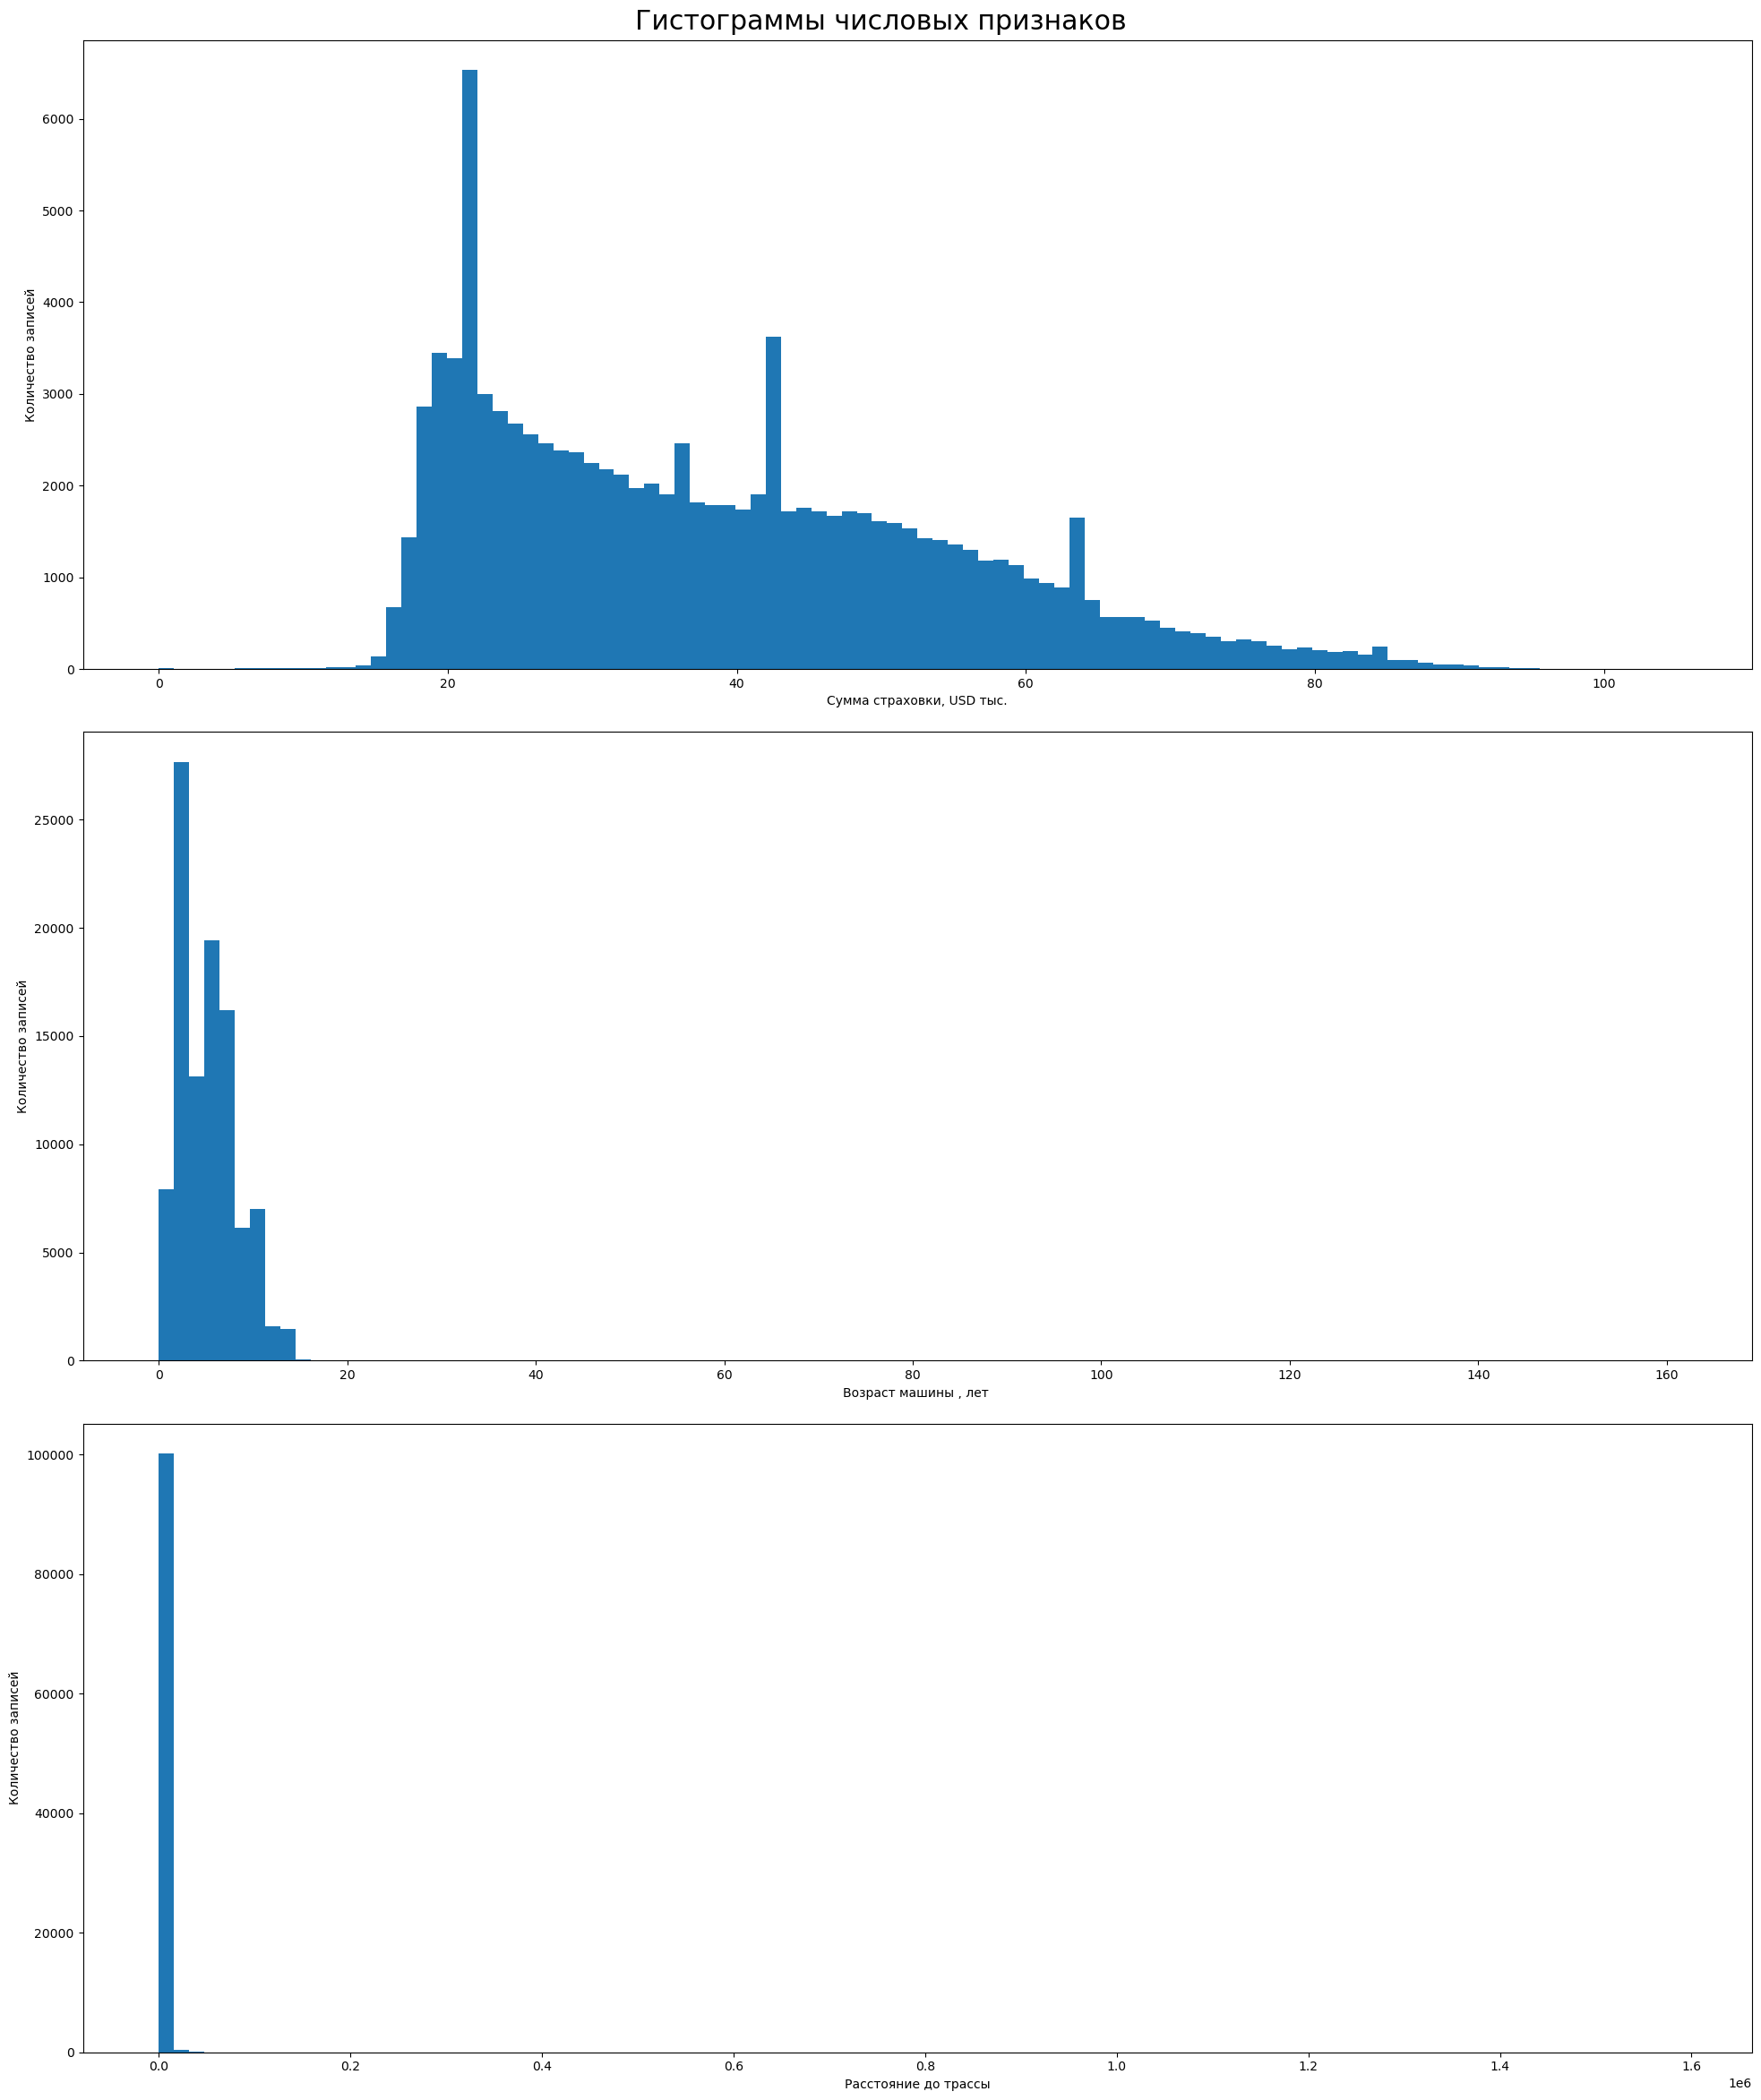

In [10]:
hist_figures,hist_axs = plt.subplots(3,1,figsize=(20,24))
hist_names =['Сумма стрaховки, USD тыс.', 'Возраст машины , лет ','Расстояние до трассы']
for i in range(len(num_cols)):    
    hist_axs[i].hist(df[num_cols[i]],bins = 100 )
#    plt.title('Гистограмма возраста машины');
    hist_axs[i].set_xlabel(hist_names[i]);
    hist_axs[i].set_ylabel('Количество записей');
plt.rcParams['font.size'] = 18
plt.suptitle('Гистограммы числовых признаков')
plt.tight_layout()    

In [11]:
df[df.vehicle_age>20]

,city,county,distance,intersection,weather_1,location_type,surface,road_condition_1,lighting,control_device,...,weekday,hour,at_fault,insurance_premium,sobriety,drug,phone,vehicle_type,vehicle_transmission,vehicle_age
25395,1942,los angeles,0.0,1,clear,ramp,dry,normal,dusk or dawn,functioning,...,4,05,0,22.0,had not been drinking,MISSING,0,sedan,manual,161
82835,1942,los angeles,449.0,0,clear,MISSING,dry,normal,daylight,none,...,4,11,1,18.0,had not been drinking,MISSING,0,sedan,manual,161


Два выброса по возрасту машины , возможно даже один и тот  же автомобиль.

In [12]:
df.loc[df.vehicle_age>20 ,'vehicle_age'] = df.vehicle_age.median()

по первой  колонке все нормально, вторая исправлена,  третья выглядит странно, но похоже дело в том, что там очень много нулей, а оставшиеся значения сильно размазаны.
Небольшое преобразование показыает что распределение здесь  тоже естественно - логарифмы значений отличных от 0, распределены нормально.


Квантили 0.4 - 0.6 для distance
 0.4     50.0
0.5    100.0
0.6    200.0
Name: distance, dtype: float64
Квантили для порядка расстояния
 0.3    2.565026
0.4    3.912043
0.5    4.605180
0.6    5.298322
0.7    5.958427
0.8    6.481579
0.9    7.367709
Name: distance, dtype: float64


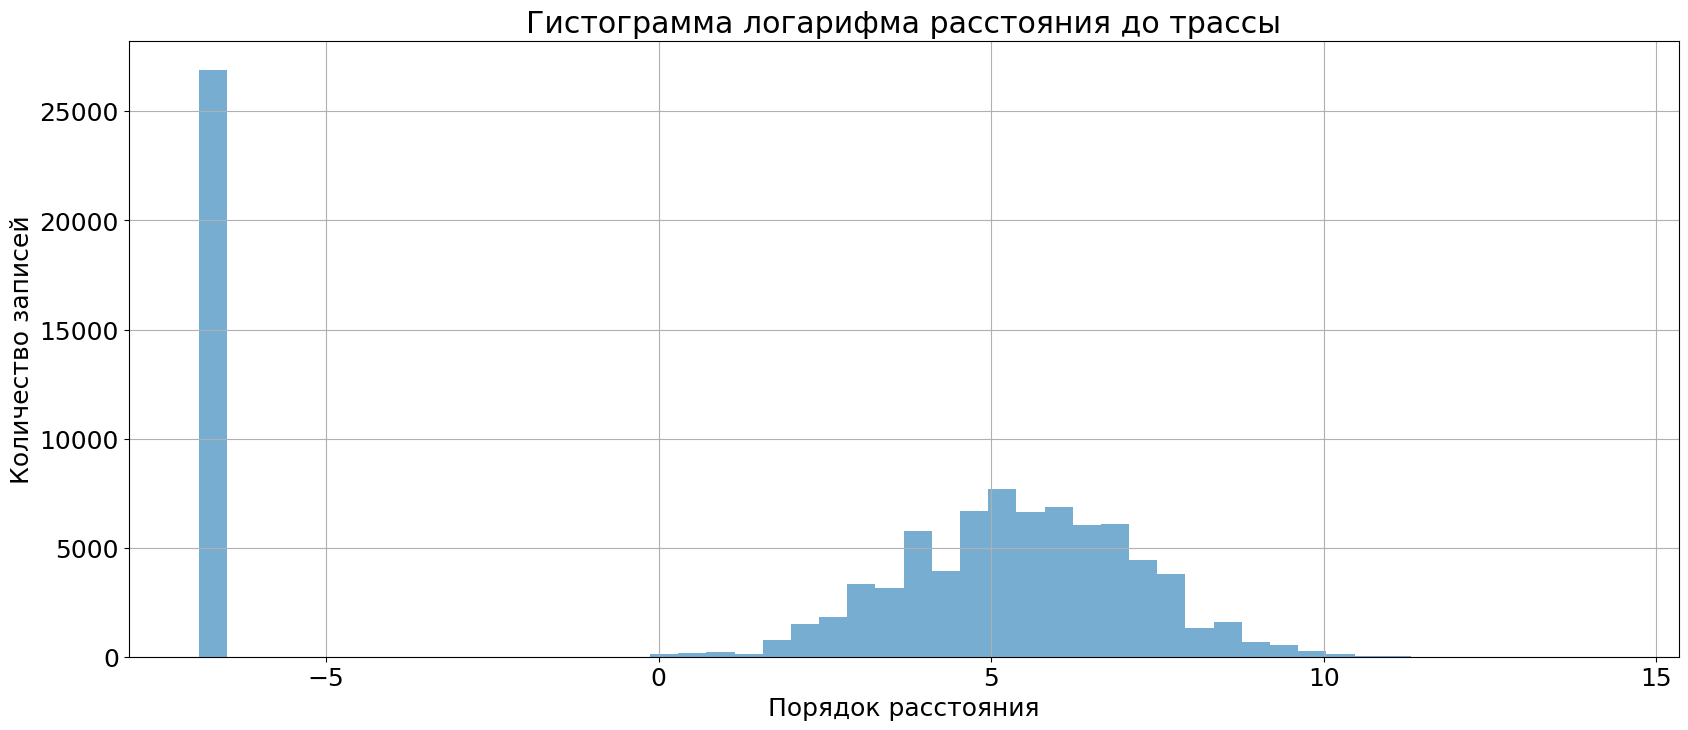

In [13]:
(df.distance+.001).apply(np.log).hist(bins=50,figsize=(20,8),alpha=.6);
plt.title('Гистограмма логарифма расстояния до трассы')
plt.xlabel('Порядок расстояния')
plt.ylabel('Количество записей')
print("Квантили 0.4 - 0.6 для distance\n", (df.distance.quantile([.4,.5,.6]) ) )
print("Квантили для порядка расстояния\n" ,(df.distance+.001).apply(np.log).quantile(list(np.arange(0.3,1,.1)) ) )

Однако расстояния  10тыс км от трассы невозможны, да и 1000 км много для Калифорнии, но такие цифры есть и распределены естественно
Их 10% и не хочется их выбрасывать (хотя на разведочной оценке пока наверно можно), и их нельзя оставлять, потому что это большие сдвиги вверх и они исказят картину

Text(0, 0.5, 'Количество записей')

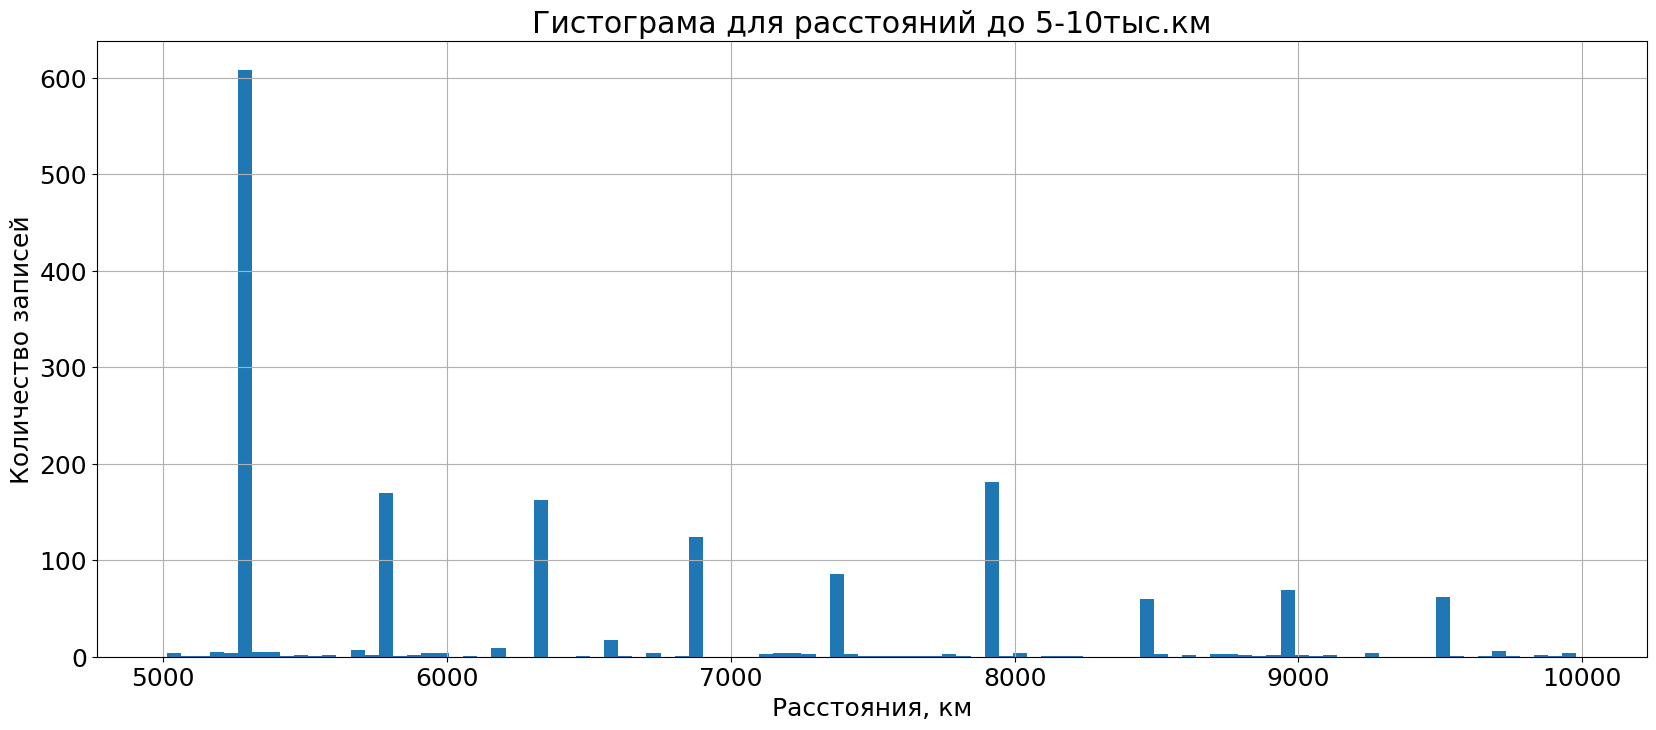

In [14]:
df.distance[(df.distance > 5_000) & (df.distance<10_000)].hist(figsize=(20,8),bins=100);
plt.title('Гистограма для расстояний до 5-10тыс.км')
plt.xlabel('Расстояния, км')
plt.ylabel('Количество записей')

Text(0, 0.5, 'Количество записей')

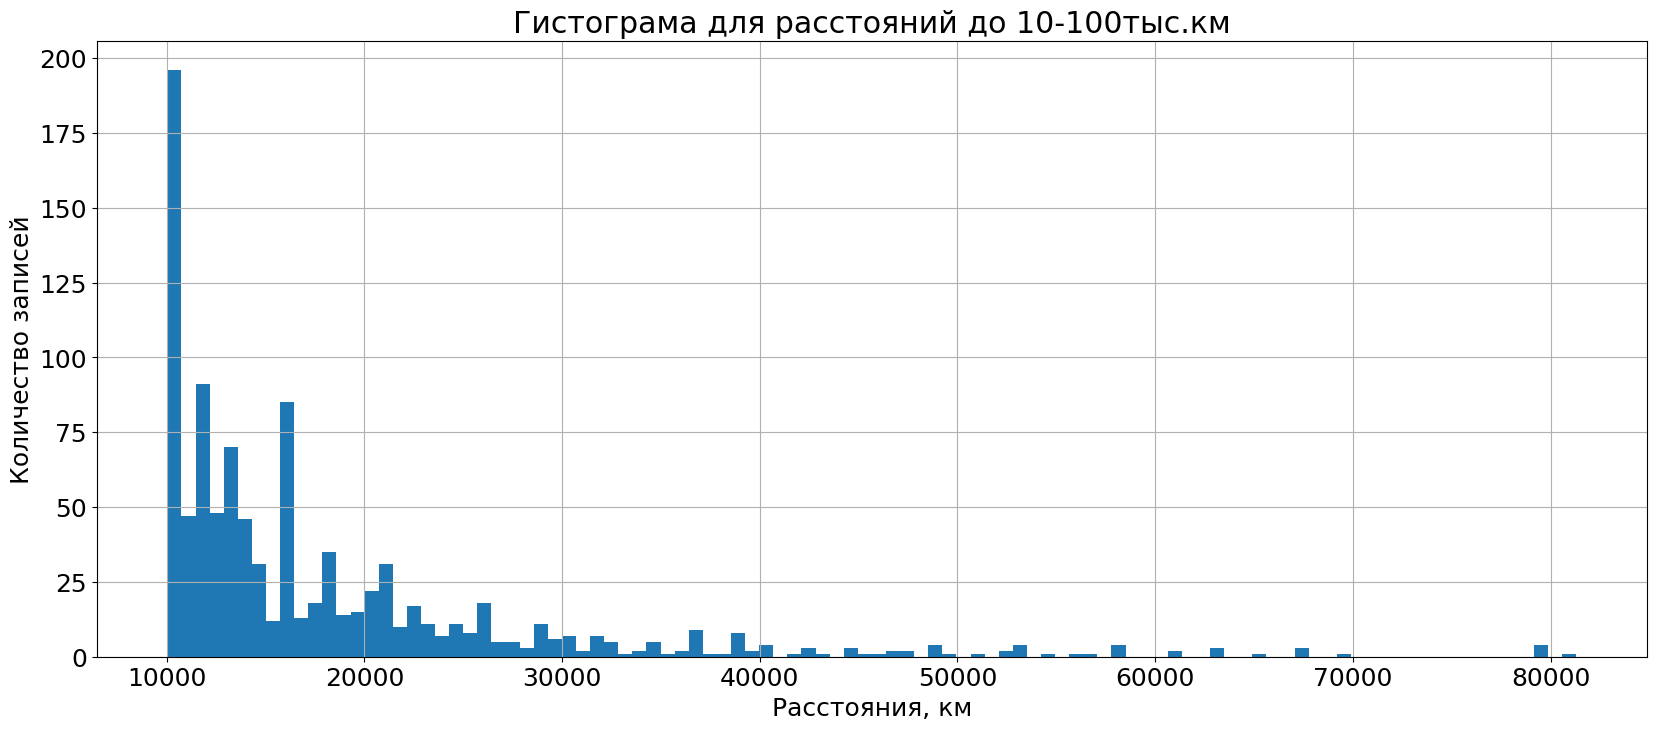

In [15]:
df.distance[(df.distance > 10_000) & (df.distance<100_000)].hist(figsize=(20,8),bins=100);
plt.title('Гистограма для расстояний до 10-100тыс.км')
plt.xlabel('Расстояния, км')
plt.ylabel('Количество записей')

Мы получим целые числа на пиках, если разделим distance на 1056

In [16]:
(df[df.distance> 1000].distance/1056).value_counts().head(20)


distance
1.000000     2372
1.500000     1738
2.500000     1609
2.000000     1052
5.000000      603
1.250000      590
1.420455      536
3.000000      505
3.500000      361
1.136364      323
1.893939      314
4.000000      307
4.500000      199
7.500000      181
5.500000      166
6.000000      162
10.000000     155
2.367424      147
1.041667      124
6.500000      124
Name: count, dtype: int64

А распределение по большим дистанциям будет очень напоминать базовое,если дистанцию поделить на 10.56

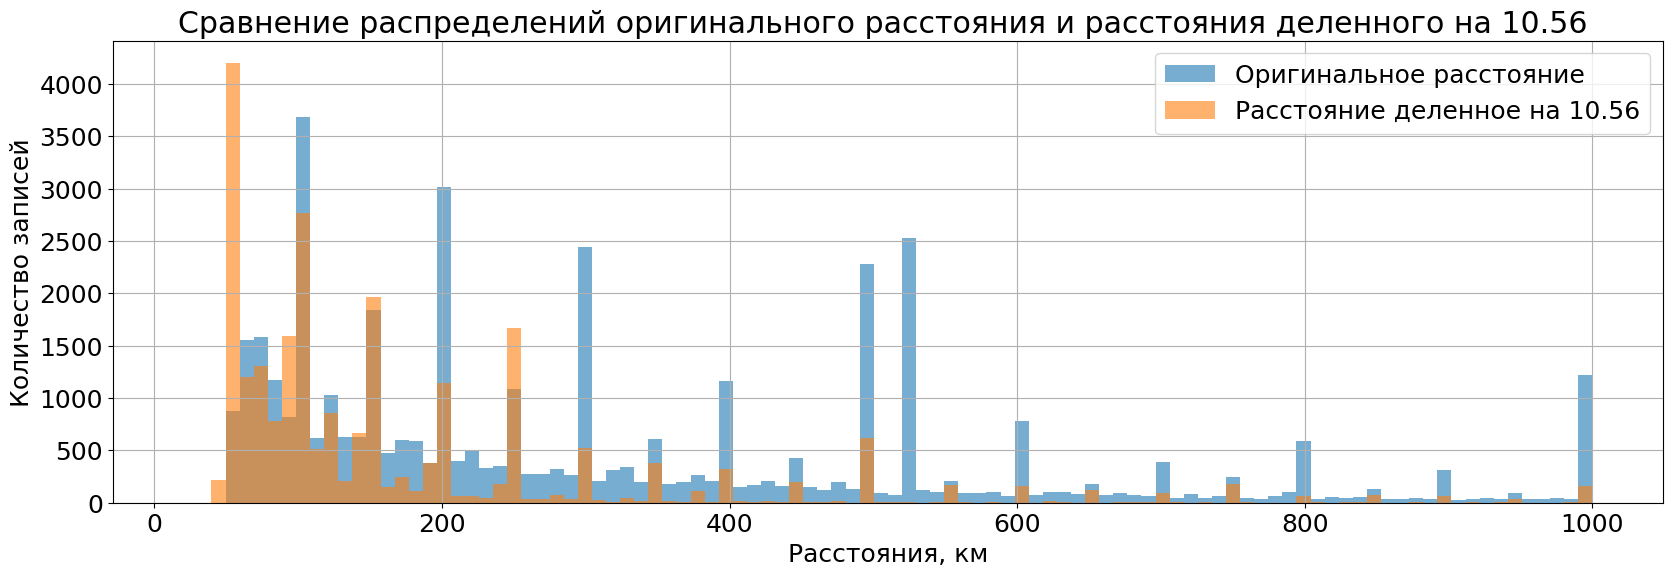

In [17]:
(df[df.distance>50].distance).hist(figsize=(20,6),bins=100,range=(20,1000),alpha=.6,label='Оригинальное расстояние');
(df[df.distance>500].distance/10.56).hist(bins=100,range=(20,1000),alpha=.6,label='Расстояние деленное на 10.56');
plt.title('Сравнение распределений оригинального расстояния и расстояния деленного на 10.56 ')
plt.xlabel('Расстояния, км')
plt.ylabel('Количество записей')
plt.legend();

Возможно здесь какой-то кривой перевод в мили, но при таких совпадениях я думаю можно верить числам даже без понимания того, что они означают. Так что в это ситуации я считаю лучшим решением поделить на 10.56 дистанции > 500  

In [18]:
df['distance']=df.distance.apply(lambda d: [d,d/10.56][d>500] )

Осталось полпроцента записей с нереальной дистанцией, для которых трудно найти закономерность, поэтому я поставлю им медиану(но по ненулевым значениям, т.к. здесь явно не нули )

In [19]:
df['distance']=df.distance.where(df.distance<1500, other=df[df.distance>0].distance.median())

##  Проведите статистический анализ факторов ДТП

для общего понимания ситуации оценим распространённость целевого признака

In [20]:
df.at_fault.mean()

0.44660358229131464

### Вред пьянства

Естественно предположить, что степень  очень сильно влияет на назначение виновника, и в общем, так оно и есть -   
пьяный признается виновным в 95 % случившихся с ним происшествий, слегка выпивший - в 71% , неясные ситуации располагаются по степени уверенности в пьянстве.   
Вероятно нужна какая-то наглядная диаграмма, но я даже не уверен, что правильно показывать - хотя пьяный почти всегда виноват, доля инцидентов с ними невелика и в общем итоге возможно мало влияет.

In [21]:
df.groupby('sobriety').at_fault.agg(['count','mean']).sort_values(by='mean',ascending=False)

,count,mean
sobriety,,
"had been drinking, under influence",5413,0.956586
"had been drinking, impairment unknown",319,0.811912
impairment unknown,1621,0.732264
"had been drinking, not under influence",801,0.714107
MISSING,1539,0.644574
had not been drinking,90321,0.404524
not applicable,592,0.347973


#### Зависимость ДТП от суммы страховки

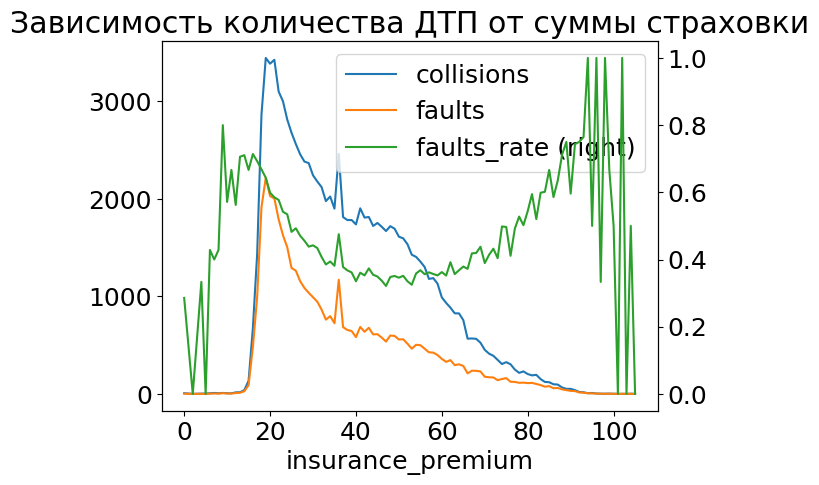

In [22]:
df_ip = df.groupby('insurance_premium').at_fault.agg(['count','sum', 'mean'])
df_ip.columns = ['collisions','faults','faults_rate']
df_ip.plot(secondary_y=['faults_rate'],title='Зависимость количества ДТП от суммы страховки');

Зависмость сложная. Видимо средний класс использует страховки на суммы $20-40K  
В этих пределах доля виновности  падает со стоимостью страховки.  
Но вне этих пределов она наоборот растёт!

#### Зависимость ДТП от возраста автомобиля

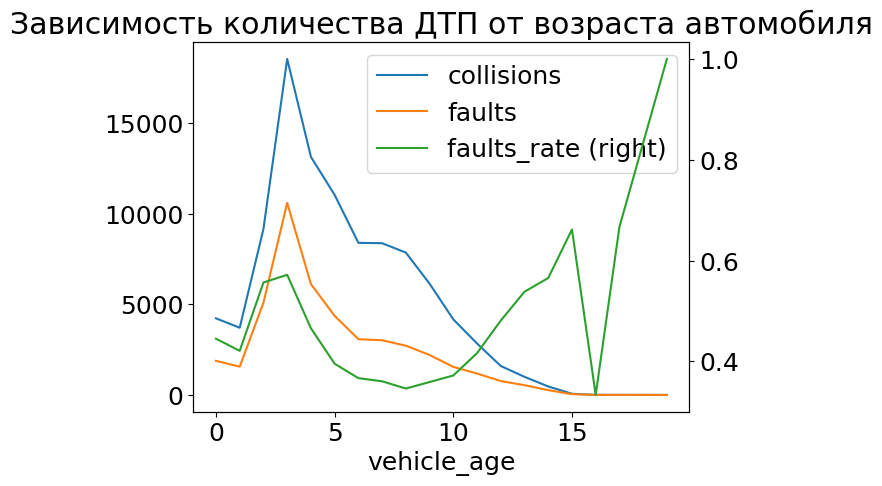

In [23]:
df_va = df.groupby('vehicle_age').at_fault.agg(['count','sum', 'mean'])
df_va.columns = ['collisions','faults','faults_rate']
df_va.plot(secondary_y=['faults_rate'],title='Зависимость количества ДТП от возраста автомобиля');


In [24]:
df_va

,collisions,faults,faults_rate
vehicle_age,,,
0,4222,1878,0.444813
1,3705,1559,0.420783
2,9146,5089,0.556418
3,18521,10588,0.571675
4,13123,6110,0.465595
5,11026,4358,0.395248
6,8385,3074,0.366607
7,8363,3014,0.360397
8,7847,2715,0.345992


Доля виновности минимальна для автомобилей возраста 5-10 лет и поднимается для крайних значений.  
Можно строить предположения о причинах, но  основной гипотезы нет.

### Распределение ДТП по месяцам

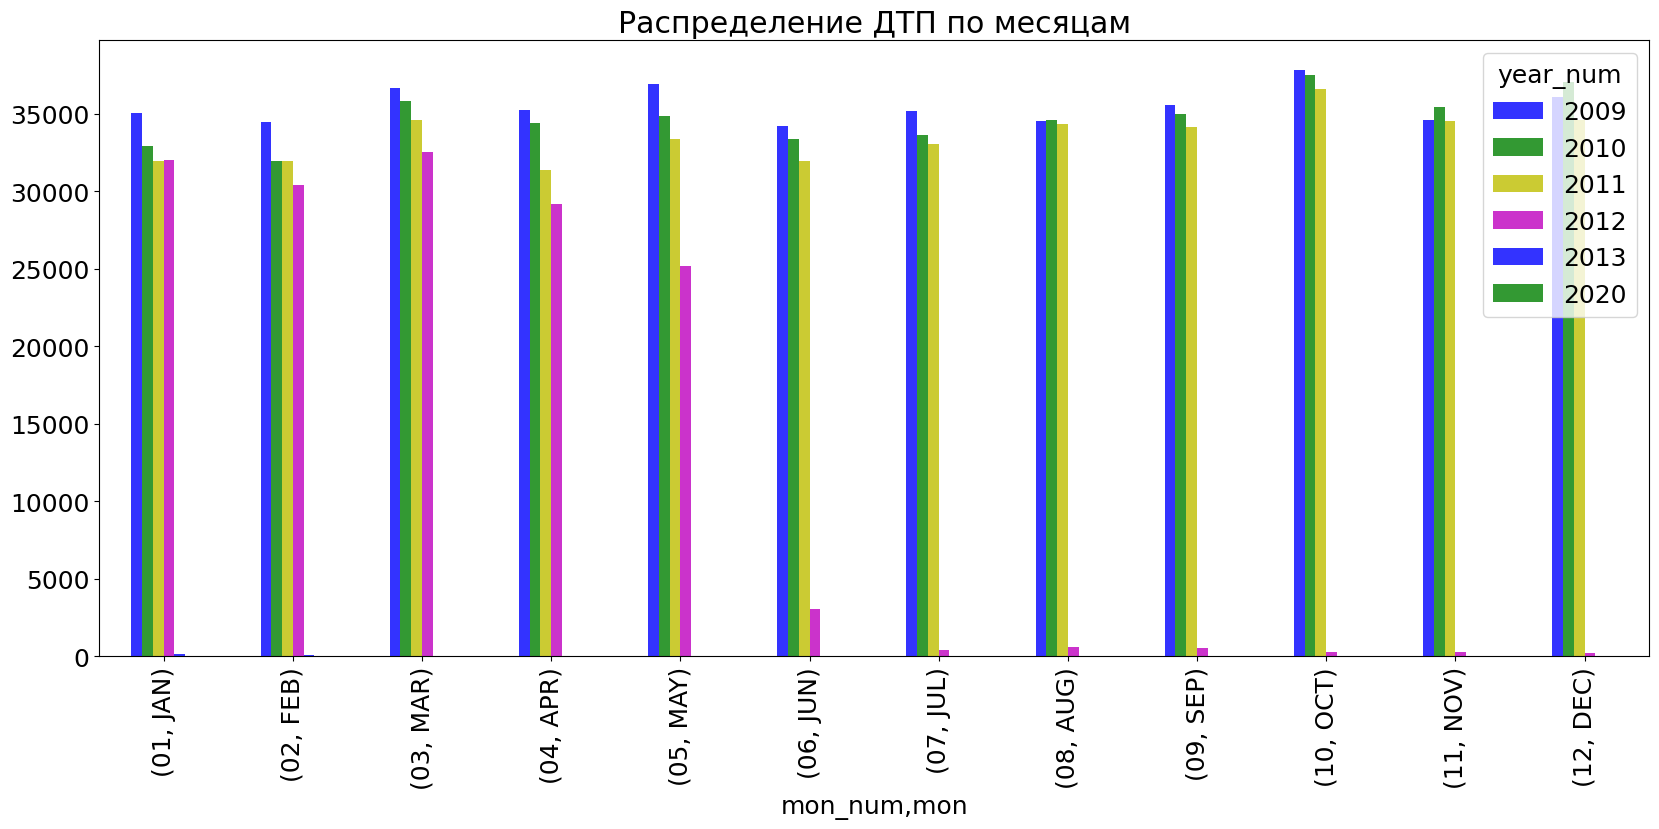

In [25]:
query = f"""
select to_char(collision_date,'YYYY') year_num,
       to_char(collision_date,'MM') mon_num,
       to_char(collision_date,'MON') mon,
       count(*) qty
  from collisions c
  where  c.collision_damage <> 'SCRATCH'
  group by 1,2,3 
  order by 2,1
"""
dm = pd.read_sql_query(query,con=engine)
dm =dm.pivot_table( index=['mon_num','mon'], columns='year_num', values= 'qty')
dm.plot.bar(title='Распределение ДТП по месяцам',
            color=['b','g','y','m'],
            alpha=.8,
            figsize=(20,8)
           );


Существуют небольшие пики в марте и конце года, но <b>самое главное - за 2012 год данные только до июня!</b>  

Это обесценивает требование использовать 2012 для анализа - надо или расширять данные за этот год или откатываться на предыдущий - осенью вполне может быть аномалия, которую мы не увидим.

###  Распределение ДТП по причинам

Иллюстративный запрос, который не может быть прямо  использован в модели (так как оба фактора неизвестны на момент предсказания), но косвенно может помочь в определении критических точек. 

In [26]:
query = '''
select pcf_violation_category,count(*) qty
 from collisions c 
 join parties p using(case_id)
 where  extract('YEAR' from c.collision_date) = 2012
  and c.collision_damage <> 'SCRATCH'
  and p.at_fault=1
 group by 1
 order by 2 desc
'''
dr = pd.read_sql_query(query,con=engine)
cutoff = .05
dr =  dr.set_index(dr.pcf_violation_category).qty 
dr  = pd.concat([dr[dr/dr.sum()>= cutoff] ,
           pd.Series( dr[dr/dr.sum()<cutoff].sum(),index=['OTHER'] )])

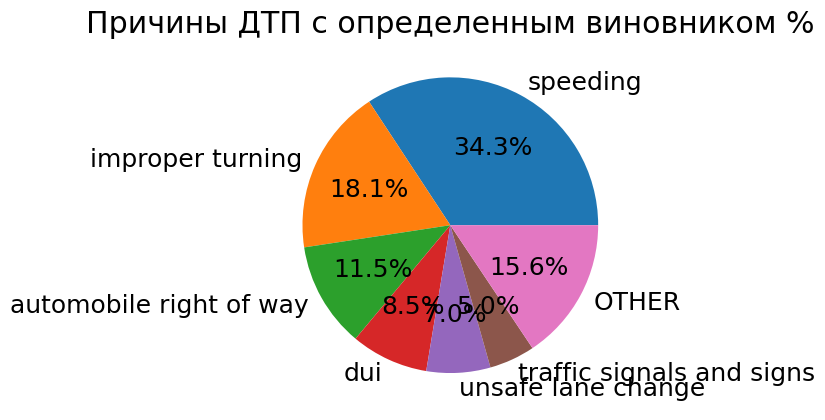

In [27]:
dr.plot.pie(autopct='%1.1f%%',title='Причины ДТП c определенным виновником %');

Половина инцидентов происходит по двум причинам - превышение скорости и неправильный поворот. Можно рассмотреть отслеживание скорости онлайн и какой-нибудь доступ к камерам на перекрёстках.

Третья по частоте причина как я понимаю - нарушение порядка проезда, так что можно ещё принимать экспресс-экзамен по ПДД :) 

### Список задач для рабочей группы

Необходимо отобрать для анализа наиболее важные для нас признаки, влиящие на ДТП  

Признаки можно разделить на объективные (одинаково относящиеся ко всем участникам ) и субъективные (различающиеся для участников). Объективные  признаки  хранятся в таблице collisions, субъективные - в таблицах parties  и vehicles.

Проблема анализа объективных признаков в том, что они мало помогают в реализации основной идеи заказчика - предсказанию вины конкретного участника.  
Объективные признаки могли бы помочь в предсказании вероятности аварии , но у нас нет данных о частоте аварий и о продолжительности беаварийной езды. Косвенно, влияние объективных признаков можно оценить по серьезности инцидентов в группе и по количеству инцидентов с одним участником.  

Субъективные признаков хорошо помогают в реализации основной идеи, но их слишком мало, чтобы строить серьехную модель, так что в дкльнейшем видимо придётся как-то привлекать объективные признаки. 

Также следует оценить возможные дополнительные целевые признаки, которые могут представлять интерес для заказчика, в частности ущерб collision_damage  и возможно primary_collision_factor и violation_category (от них может зависеть размер страховых выплат) . Эти признаки неизвестны в момент предсказания и в любом случае не могут  быть учтены в модели, но могут быть предсказаны. 

Окончательная постановка задачи зависит от того, что хояет получить заказчик, здесь есть некоторая неясность -   
с одной стороны, надо предсказывать вероятность аварии в конкретной ситуации, для чего не хватет данных 
с другой - предсказывать виновника, для чего годится только несколько признаков из таблицы parties.

Я также  предполагаю, что интересует не только виновник, но и потенциальный ущерб от него , но пока задача так не ставится и нет целевой функции (ущерб можно предположить по размерам страховки, но непонятно какой реальный ущерб несёт в каждом случае компания). 

Предварительно, я бы выделил такие задачи (список будет уточнён по резултатам моделирования)
* Установить связь между физическим состоянием участника ДТП (трезвость, степень опъянения и усталость)  и виновностью , а также тяжестью аварии
* Проверить наличие связи между суммой страховки и виновностью, а также тяжести повреждений
* Доля в общей стоимости инцидентов (понимаемой как сумма страховки) различных субъективных причин(по крайней мере пьянства и <s>возраста автомобиля</s>)
    - Создать подзапрос collision_costs к базе данных, вычисляющий для каждого инцидента сумму страховок участников: 
        - для этого сгруппировать данные по case_id и вычислить сумму страховок участников для каждого инцидента
    - С помощью этого подзавроса посчитать суммарную стоимость страховок для каждой категории виновников по sobriety, 
        - для этого связать вторую копию parties c collision_costs по саse_id, 
        - сгруппировать по sobriety и отфильтровать по признаку виновности at_fault=1, 
        - суммировать стомиость страховок и количество инцидентов по группам, 
        - также вычислить средние стоимость инцидентов с помощью функции avg
    - Загрузить запрос в датафрейм, пересчитать количество и суммарную стоимость страховок в проценты
    - Иллюстрировать результаты круговыми диаграммами, сравнить их между собой
    - Построить столбчатую диаграмму для средней стоимости инцидента в зависимости от трезвости



* Проверить наличие связи между локацией (город + графство) и виновностью водителя в ДТП с одним участником.

    - Построить запрос:
        - связать таблицы collisions и partis по case_id
        - применить ограничения по году, количеству участников(party_count=1), типу аварии
        - применить группировку по городу и для каждого города:
        - найти количество записей в базе(count)
        - найти количество виновников,просумировав fault_at
        - найти количество пьяных просуммировав 1 для инцидентов с пьяными водителями
    - загрузить запрос в датафрейм
    - в датафрейме посчитать доли виновных и пьяных водителей по городам
    - найти коэффициент корреляции между этими векторами
    - для 10 крупнейших по количеству инцидентов городов вывести доли виновных и пьяных на столбчатую диаграмму
    - повторить процедуру для другого  уровня повреждений


* Прверить связь между локацией и причинённым ущербом
* Есть ли локации,  доля которых в авариях выросла за время наблюдений?

## Создайте модель для оценки водительского риска

Выбор признаков для модели описан в комментарии к основному запросу данных для модели, часть 2

Я стремился работать с моделями по возможности одинаково, убирая код в стандартыне классы, так чтобы различались тольок тип модели и решетка параметров. Для градиентного бустинга выбраны модели LGBM  и Catboost, для нейросети - MLP. Насколько я понял из документации, при поиске оптимума все градиентные алгоритмы бинарной классификации используют оценку log_loss/cross_entropy. 
Для каждой модели  запускается кроссвалидация на тренировочном наборе и лучший набор параметров проверяется на тестовом наборе.   
Затем формируются  графики зависимости от параметров.
Для оценки влияния признаков используется билиотека SHAP

### Вспомогательные классы для обучения модели и анализа результата

Вспомогательные классы для сбора результатов кроссвалидации и их отрисовки

#### Parsed Result

Этот класс собрает из результатов кроссвалидации фрейм с мультииндексомм по колонкам,
соответвующим нетривиальным слоям тестируемой решетки. 

In [28]:
class ParsedResult:
    def __init__(self,result,force_string_cols=[],metric_name='score'):
        self.df = pd.DataFrame.from_dict( 
            { k:v for k,v in result.items() if k not in ['params']}
        )
# drop param_ prefix from column names for tidy display         
        self.primary_score='mean_test_'+metric_name
        param_names = [ c for c in self.df.columns if c[:6]=='param_' ]        
        self.param_cols = [ c[6:] for c in param_names ]              
        self.df = self.df.rename( columns={ p:c for p,c in zip(param_names,self.param_cols) } )
# also drop model_ prefix which we use for model grid in pipeline   
        model_names = [ c for c in self.df.columns if c[:7]=='model__' ]
        self.param_cols = [c[7:]  if c[:7]=='model__' else c for c in self.param_cols ]
        self.model_cols = [ c[7:] for c in model_names ]   
        self.df = self.df.rename( columns={ p:c for p,c in zip(model_names,self.model_cols) } )
# select parameters, for which tested several values and arrange them descending (by number of differnt values)
        values_per_cols = list(zip( self.param_cols,[ len( np.unique( self.df[c].values ) ) for c in self.param_cols]))
        self.multi_value_cols =[it[0] for it in sorted(values_per_cols, key=lambda pair:pair[1],reverse=True) if it[1]>1 ]
# some object columns may be not string (f.e. lists)
        for c in force_string_cols:
            self.df[c]=self.df[c].apply(str)
    
    def select(self, index,values=[],filters={},agg=[] ):
        values = [ [self.primary_score] ,values][bool(values)]
        if len(filters)>0 :
            condition = 'and'.join([ f" {k}=={v} " for k,v in filters.items() ]) 
            filtered = self.df.query(condition)    
        else:
            filtered = self.df
        cols = [ c for c in self.multi_value_cols if c not in list(filters.keys())+[index]+values ]      
        return(self.df.pivot_table(index=index,values=values,columns=cols)  )

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b>

<b>✅«Отлично»:</b> Молодец, что используешь классы, это позволяет сильно оптмизироват код. 

#### ResultPlotter

Два класса для отрисовки графиков :    
Вспомогательный класс формирования аттрибутов линий для графиков, создаваемых в основном плоттере

In [29]:
class Styler:
    base_array=[]
    def __init__(self,param_array=[]):
        self.params = [ self.base_array,param_array][bool(param_array)]
    
    def key(self):
        pass
    
    def put(self,dct,index):
        dct[self.key()] = self.params[index]
        
class ColorStyler(Styler):
    base_array=[*'rgbykm']
    def key(self):
        return('color')

class DashStyler(Styler):
    base_array=['--',':','-.','-']
    def key(self):
        return('ls')
    
class WidthStyler(Styler):
    base_array=[ 2,4,7]
    def key(self):
        return('lw')

class AlphasStyler(Styler):
    base_array=[ .3,.9]
    def key(self):
        return('alpha')
    

И собственно плоттер, рисующий каждый столбец мультиколонки в своем стиле.   
Отельные непересекающиеся аттрибуты создаются для каждого уровня мультиколонки,   
в результате каждая элементарная подколонка получает уникальный стиль   

In [30]:
class ResultPlotter:
    base_params = {
        'colors':[*'rgbykm'],
        'styles':['--',':','-.','-'],
        'widths':[ 2,4,7],
        'alphas':[.3,.8],
        'figsize': (20,8),
        'logscale':""
    }
    
    def __init__(self, test, params = {} ):
        self.model = test.model
        self.df= test.sel
        self.params=self.base_params | params
        self.stylers = [ColorStyler(self.params['colors']),DashStyler(self.params['styles']),
                        WidthStyler(self.params['widths']),AlphasStyler(self.params['alphas'])]
        self.mcols = self.df.columns
        self.lev_names = self.mcols.names[1:]
        self.num_levels= len(self.lev_names)
        self.level_sizes=[ len(set(self.mcols.get_level_values(x))) for x in self.lev_names]

# auxliary func to forms sequence of indexes for levels
# result is need index on the level  which may be one of color|dashstyle|linewidth
    def idx_on_level(self,idx, lev_num):
        items_on_hyperplane = multiply(self.level_sizes[(lev_num+1):]) 
        return idx//items_on_hyperplane% self.level_sizes[lev_num]
    
    def plot(self):
        fig,ax = plt.subplots(figsize=(20,6))
        if 'x' in self.params['logscale'].lower():
            ax.set_xscale('log')
        
        for i in range(len( self.mcols)):
            graph_params = {}
            for i_level in range(self.num_levels):
                self.stylers[i_level].put( graph_params, self.idx_on_level(i,i_level) ) 
            idx=self.mcols[i]
            
            graph_params['label'] = ','.join( [ f"{n}:{i} " for n,i in zip(self.lev_names,idx[1:]) ] )
            ax.plot(self.df[idx] ,**graph_params)
            ax.set_title(f'Тест {type(self.model).__name__}')
            ax.set_xlabel('learning rate')
            ax.set_ylabel('log_loss metric')
            ax.legend()

#### Класс для универсального теста на модели

Содержит программу стандартного теста

In [31]:
def plot_pr(y,proba):
    precision, recall, thresholds = precision_recall_curve(y, proba[:, 1])
    plt.figure(figsize=(10, 6))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show() 

In [32]:
class TestModel:
    def __init__(self, model,fit_params={},scoring=['f1','roc_auc'] ):
        self.model = model
        self.fit_params=fit_params
        self.scoring = scoring
        
    def cross_validate(self,param_grid,X_tr,y_tr,refit=None):
        self.refit = [self.scoring[0],refit ][bool(refit)]
        self.cv = GridSearchCV(self.model, param_grid,cv=4, scoring=self.scoring,refit=self.refit,return_train_score=True) 
        self.cv.fit(X_tr,y_tr,**self.fit_params)
        self.best = self.cv.best_params_
        return self.best
    
    def check_best(self,X_tr,y_tr,X_te,y_te):
        model = self.model.set_params(**self.best)
        model.fit(X_tr,y_tr,**self.fit_params)
        pr = model.predict(X_te)
        for metric in [f1_score,precision_score,recall_score,accuracy_score]:
            print(f"{metric.__name__}: {metric(y_te,pr)} \t")
        print( "confusion_matrix:\n",confusion_matrix(y_te,pr) )
        proba = model.predict_proba(X_te)
        plot_pr(y_te,proba)
    
    def parse_result(self,index_column='learning_rate',forced_string_cols=[]):
        self.res = ParsedResult(self.cv.cv_results_,forced_string_cols,metric_name=self.refit)
        self.sel = self.res.select(index_column)
        return self.sel
        
    def plot(self):
        self.rp = ResultPlotter(self,{'logscale':'x'})
        self.rp.plot()
         

### Описание структуры данных и  разбиение на тренажер и тест

In [33]:
y = 'at_fault'
X = [ c for  c in df.columns if c!=y ]
cat_cols = [ c for c in df.columns if df.dtypes[c] in [ 'object','category']  ] 
num_cols = [ c for c in df.columns if df.dtypes[c] in ['int','int64','float','float64' ] ]

In [34]:
df.dtypes

city                     object
county                   object
distance                float64
intersection             object
weather_1                object
location_type            object
surface                  object
road_condition_1         object
lighting                 object
control_device           object
month                    object
weekday                  object
hour                     object
at_fault                  int64
insurance_premium       float64
sobriety                 object
drug                     object
phone                    object
vehicle_type             object
vehicle_transmission     object
vehicle_age               int64
dtype: object

In [35]:
for c in cat_cols:
    df[c] = df[c].astype('category')


In [36]:
X_tr,X_te,y_tr,y_te = train_test_split(df[X],df[y], test_size = .25, stratify = df[y], shuffle= True ) 

#### Выбор метрики
Нам важно не показывать сообщения и не проводить проверки при <i>false-positive</i>  - излишние процедуры будут нервировать водителей и они будут уходить к конкурентам, т.е. нам важно определять <i>precision</i>.    
Однако так как речь идет о безопасности жизни водителя и пешеходов, то нам также важно определять <i>recall</i>.
    
Поэтому логичным выбором будет  F1 - метрика объединяющая <i>precision</i> и <i>recall</i>

### Выбор модели

#### LGBM

In [37]:
%%time
params_grid = {
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['binary'],
    'is_unbalance':[True,False],
    'learning_rate': [.3,.1,.03,.01,.003],
    'n_estimators': [128,256,512],
#    'n_estimators':[16],
    'boosting' :['gbdt','dart'],
    'max_depth':  [256],
    'num_leaves': [512]       
}
lgbm = TestModel(lgb.LGBMClassifier( verbose = -1))
lgbm.cross_validate(params_grid,X_tr,y_tr)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boostin

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boostin

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boostin

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boostin

{'boosting': 'dart',
 'is_unbalance': True,
 'learning_rate': 0.03,
 'max_depth': 256,
 'n_estimators': 256,
 'num_leaves': 512,
 'objective': 'binary',
 'subsample': 0.25,
 'subsample_freq': 4}

f1_score: 0.5856895556837854 	
precision_score: 0.6368294468263097 	
recall_score: 0.5421525861301523 	
accuracy_score: 0.6574427480916031 	
confusion_matrix:
 [[10446  3473]
 [ 5143  6090]]


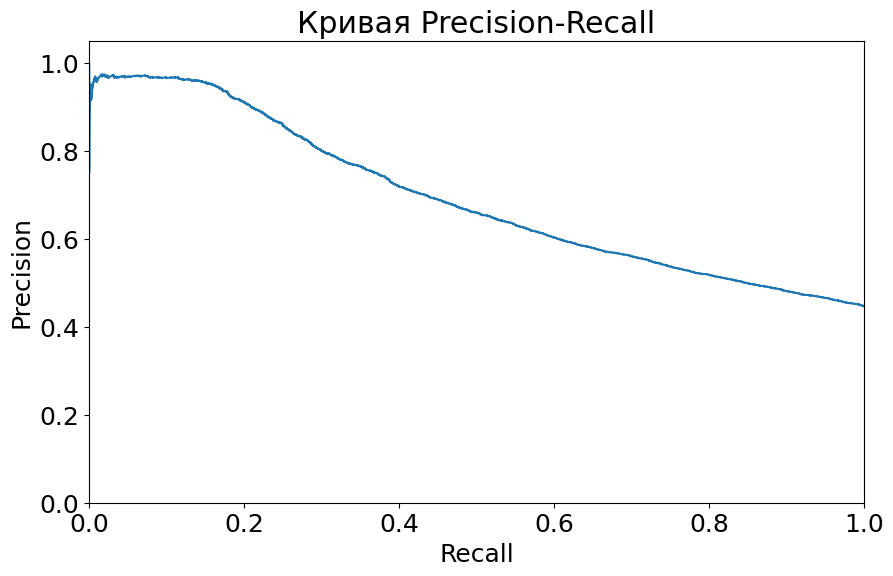

In [38]:
from sklearn.metrics import precision_recall_curve
lgbm.check_best(X_tr,y_tr,X_te,y_te)

 Матрица ошибок перекошена в сторону FN 
 Лучшая целевая метрика .578 при этом точность .65

In [39]:
lgbm.parse_result()

mean_test_f1                                                    \
n_estimators           128                                     256             
boosting              dart                gbdt                dart             
is_unbalance         False     True      False     True      False     True    
learning_rate                                                                  
0.003             0.392651  0.443282  0.438153  0.484759  0.510713  0.550561   
0.010             0.521086  0.560082  0.537124  0.571839  0.547152  0.581856   
0.030             0.551610  0.583818  0.555035  0.582305  0.557126  0.585307   
0.100             0.549759  0.573734  0.547630  0.558781  0.550389  0.569302   
0.300             0.541357  0.549683  0.527242  0.534924  0.537357  0.542708   

                                                                           
n_estimators                            512                                
boosting           gbdt                dart                gbdt            
is_unbalance      False     True      False     True      False     True   
learning_rate                                                              
0.003          0.512158  0.551968  0.539751  0.576715  0.542661  0.576071  
0.010          0.553194  0.584853  0.553728  0.584440  0.557125  0.581839  
0.030          0.555050  0.575544  0.553706  0.579463  0.548618  0.564108  
0.100          0.539073  0.549228  0.543814  0.558138  0.531581  0.539294  
0.300          0.525570  0.528990  0.531494  0.535492  0.523158  0.525770

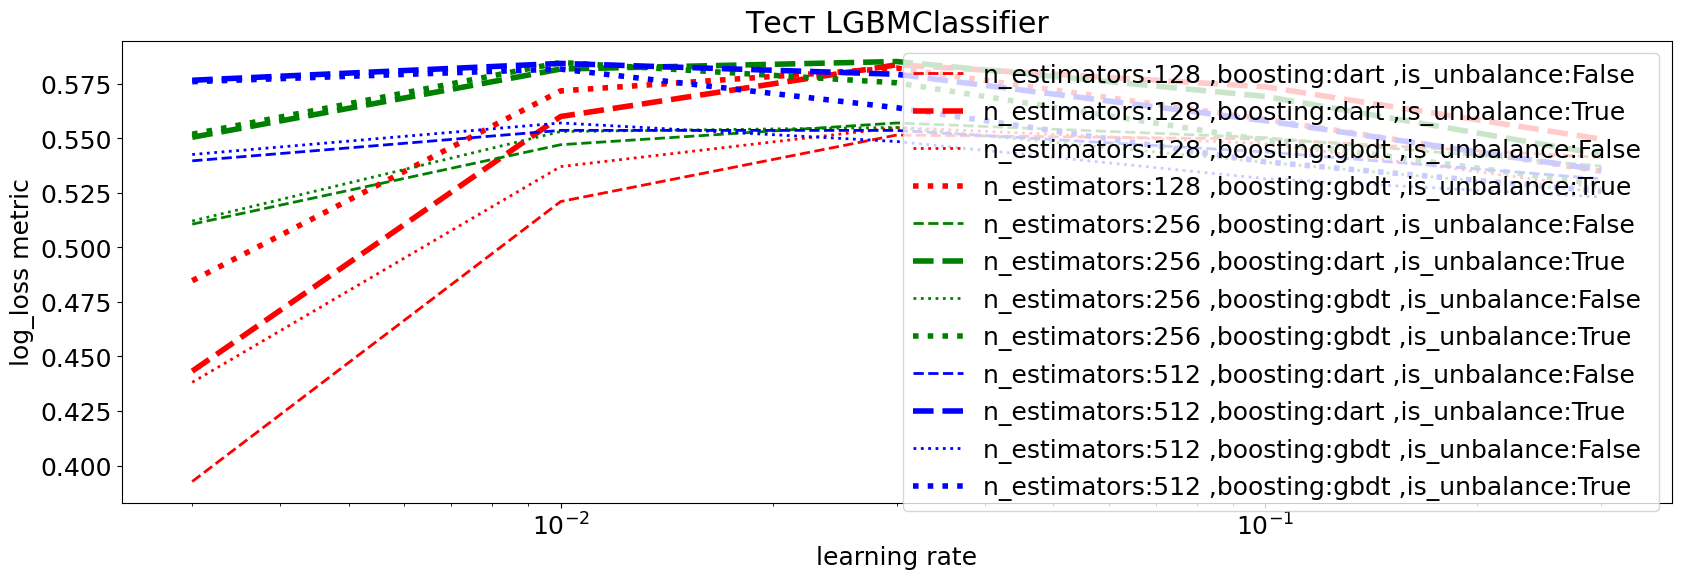

In [40]:
lgbm.plot()

Лучший результат при скоростях обучения 0.03-0.1  
При таких скоростях  результат довольно стабилен 

#### Catboost

Хотя модель позволяет задавть не только функцию потерь но и финальную метрику, похоже при тренировке/кроссвалидации этот параметр не учитывется и в качестве test_score выводится функция потерь. 

In [41]:
cbst = TestModel(cbs.CatBoostClassifier(logging_level='Silent' ),fit_params={'cat_features':cat_cols})
params_grid = {
    'loss_function' :['Logloss'],
    'eval_metric':['F1'],
    'scale_pos_weight':[.5,1,2],
    'iterations': [64,128,256,512],
    'learning_rate': [.6,.3,.1,.03,.01,.003]
}
cbst.cross_validate(params_grid,X_tr,y_tr)

{'eval_metric': 'F1',
 'iterations': 512,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'scale_pos_weight': 2}

f1_score: 0.6740216948650549 	
precision_score: 0.5769425782735454 	
recall_score: 0.8103801299741832 	
accuracy_score: 0.6499284351145038 	
confusion_matrix:
 [[7244 6675]
 [2130 9103]]


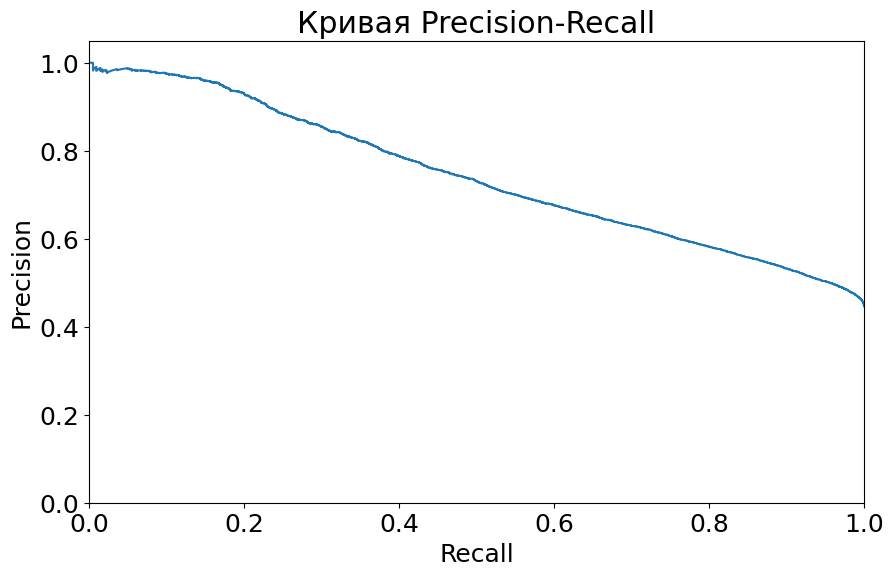

In [43]:
cbst.check_best(X_tr,y_tr,X_te,y_te)

F1 гораздо лучше - .67
Модель также перекошена но в другую сторону (FP). Точность примерно такая же как  у LGBM 

In [44]:
cbst.parse_result()

mean_test_f1                                          \
iterations                64                            128             
scale_pos_weight          0.5       1.0       2.0       0.5       1.0   
learning_rate                                                           
0.003                0.300286  0.508838  0.625535  0.300683  0.511167   
0.010                0.304038  0.512232  0.626297  0.310647  0.512850   
0.030                0.314677  0.517653  0.632523  0.341055  0.535897   
0.100                0.362301  0.544172  0.636107  0.379878  0.550036   
0.300                0.391403  0.550796  0.636137  0.400215  0.551309   
0.600                0.404492  0.551098  0.633349  0.410843  0.550610   

                                                                              \
iterations                       256                           512             
scale_pos_weight       2.0       0.5       1.0       2.0       0.5       1.0   
learning_rate                                                                  
0.003             0.626205  0.309275  0.511988  0.626414  0.317047  0.516150   
0.010             0.628143  0.327125  0.528019  0.634923  0.356003  0.546069   
0.030             0.635113  0.372626  0.554080  0.640788  0.401836  0.572273   
0.100             0.635795  0.414144  0.580991  0.662183  0.429345  0.586503   
0.300             0.635622  0.437247  0.590367  0.661501  0.453109  0.591395   
0.600             0.631746  0.461880  0.592585  0.654243  0.489030  0.592303   

                            
iterations                  
scale_pos_weight       2.0  
learning_rate               
0.003             0.632392  
0.010             0.637747  
0.030             0.657885  
0.100             0.664944  
0.300             0.661189  
0.600             0.648272

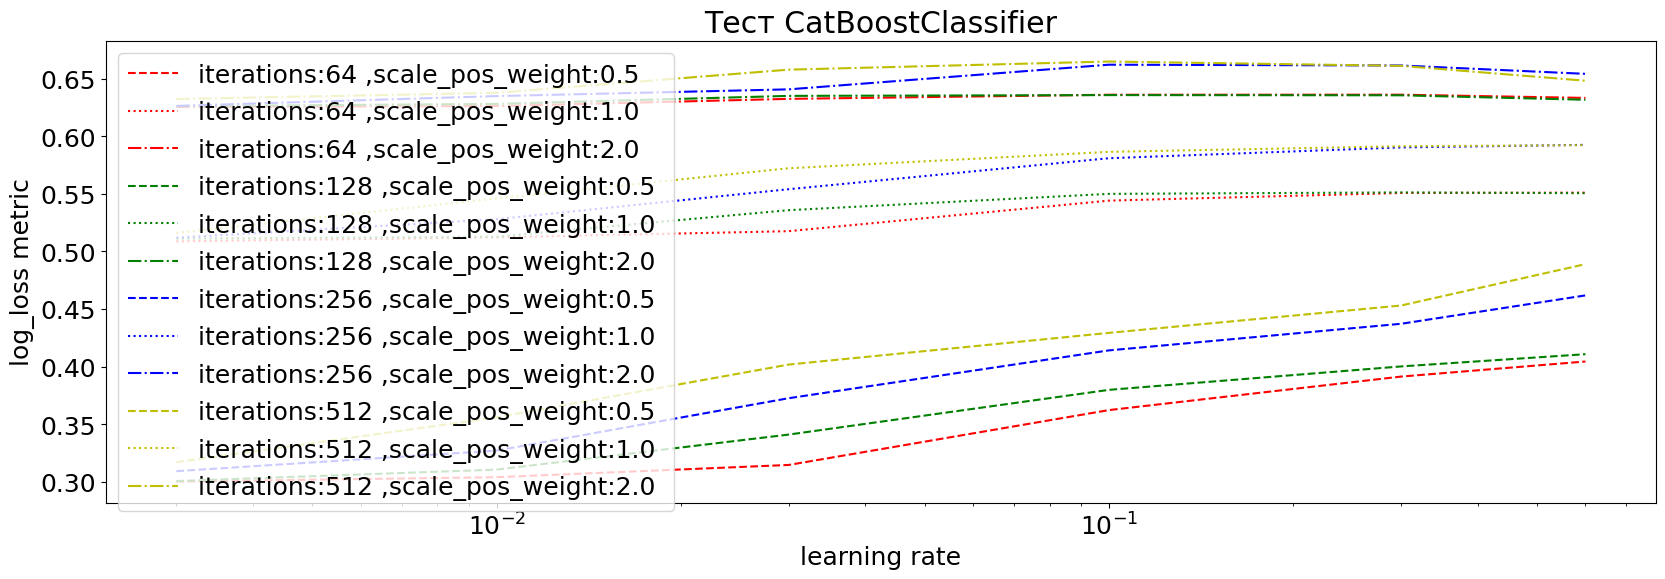

In [45]:
cbst.plot()

Модель позволяет получить метрику ~0.67 при скоростях обучения 0.1-0.3  
Увличение итераций позволяет улучшить модель, также максимумы смещены в правый край диаграммы  и там четкого спада нет  
Возможно модель немного недообучена, но увеличивать обучение можно только количеством итераций и она становится медленной.  
F1 улучшается при поправке на дисбаланс, это следует учесть в дальнейшем и попробовать настроить параметр более точно

#### MLPClassifier

Для унификации расчета и использования одного набора данных  трансформеры убраны в пайплайн.
Проверялись трехуровневая и одноуровневая модели.  
Также не предварительрных тестах проверялся оптимизатор lbfgs но он не показал никаких преимуществ и был критически медленным на трехуровневой модели.  
Я не неашел возможности поставить разные активаторы на разных уровнях и так как для классификации последним должен быть logistic(сигмоид) выбора здесь практически нет ,  

In [46]:
%%time
ohe_pipe = OneHotEncoder(min_frequency =5_000,handle_unknown='infrequent_if_exist',drop='first')
ctr_pipe = ColumnTransformer( 
        [('encoder-scaler', ohe_pipe, cat_cols)], 
        remainder=StandardScaler(),
        verbose_feature_names_out = False
    )
mlp_pipe =  Pipeline(steps = [
    ['encoder',  ctr_pipe  ],
    ['model',MLPClassifier( max_iter=1_000)]
])
mlp = TestModel(mlp_pipe)
params_grid = {
   'model__hidden_layer_sizes':[ [8], [24,8,4] ],
   'model__solver': ['adam'],
   'model__activation': ['logistic'],
   'model__early_stopping': [ True],
   'model__learning_rate_init':  [.3,.1,.03,.01,.003]  
}

mlp.cross_validate(params_grid,X_tr,y_tr )

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as al

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


CPU times: total: 22min 36s
Wall time: 7min 5s


{'model__activation': 'logistic',
 'model__early_stopping': True,
 'model__hidden_layer_sizes': [8],
 'model__learning_rate_init': 0.1,
 'model__solver': 'adam'}

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


f1_score: 0.5362178452265633 	
precision_score: 0.677915362634372 	
recall_score: 0.4435146443514644 	
accuracy_score: 0.6573632315521628 	
confusion_matrix:
 [[11552  2367]
 [ 6251  4982]]


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


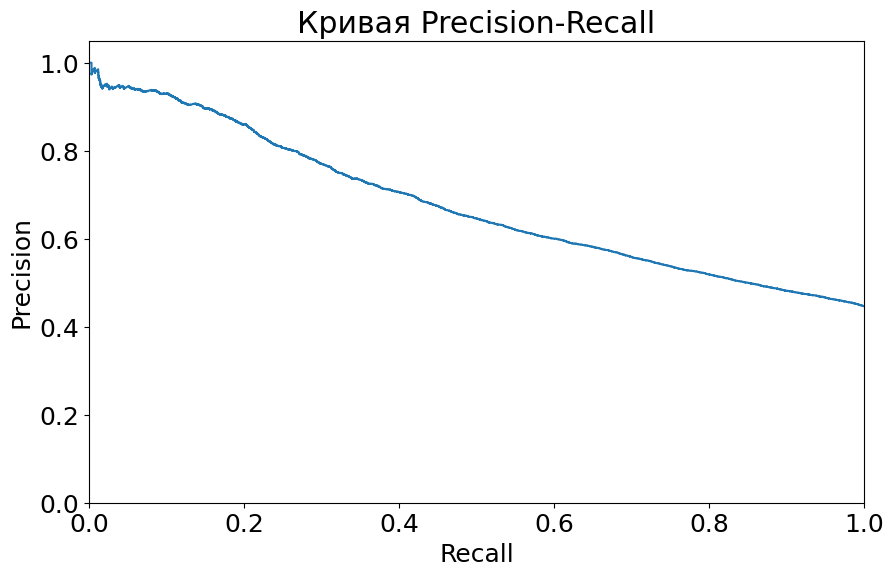

In [47]:
mlp.check_best(X_tr,y_tr,X_te,y_te)

Лучший результат по точности, но гораздо более  низкая F1 из-за большого числа ложноотрицательных результатов 

In [48]:
mlp.parse_result( index_column='learning_rate_init',forced_string_cols=['hidden_layer_sizes'] )

mean_test_f1          
hidden_layer_sizes   [24, 8, 4]       [8]
learning_rate_init                       
0.003                  0.535930  0.544005
0.010                  0.540675  0.547447
0.030                  0.539940  0.537452
0.100                  0.520875  0.548997
0.300                  0.232922  0.525759

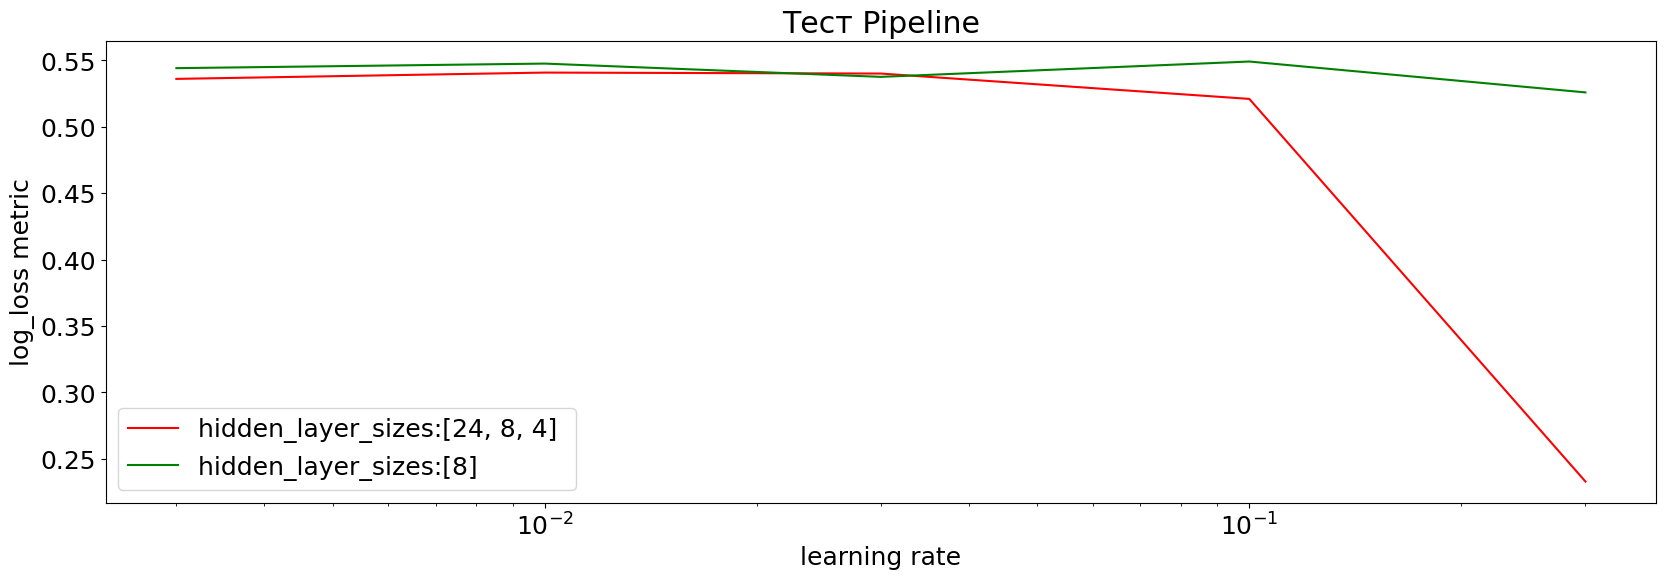

In [49]:
mlp.plot()

Увеличение количества уровней не улучшило модель 
В целом по предварительным результатам нейросеть проигрывывает CatBoost, хотя у нейросети может быть многовариантов настройки и все их не сейчас проверить 

### Torch neural network

#### Transform for neural network

In [50]:
ohe = OneHotEncoder(min_frequency =5_000,drop='first',sparse_output=False,handle_unknown='infrequent_if_exist')
ctr = ColumnTransformer( 
        [('encoder-scaler', ohe, cat_cols)],
        remainder=StandardScaler(),
#        sparse_threshold=0,
        verbose_feature_names_out = False
    )
ctr.fit(X_tr)
new_cols = ctr.get_feature_names_out()
tX_tr = pd.DataFrame( ctr.transform(X_tr) , columns = new_cols )
tX_te = pd.DataFrame( ctr.transform(X_te) , columns = new_cols ) 
input_neurons = len( tX_tr.columns )
tX_te.head()



Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


,city_infrequent_sklearn,county_orange,county_san diego,county_infrequent_sklearn,intersection_ 1,intersection_infrequent_sklearn,weather_1_cloudy,weather_1_infrequent_sklearn,location_type_highway,location_type_infrequent_sklearn,...,drug_infrequent_sklearn,phone_MISSING,phone_infrequent_sklearn,vehicle_type_sedan,vehicle_type_infrequent_sklearn,vehicle_transmission_manual,vehicle_transmission_infrequent_sklearn,distance,insurance_premium,vehicle_age
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.160718,0.630411,0.254393
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.767067,-1.274923,-0.729074
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.767067,-0.906149,-0.401252
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.674288,-0.537374,-1.384719
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098866,-0.352987,-0.073429


### Custom Torch Neural network

Рекомендованная в курсе модель на основе Torch.
К сожалению не получилось встроить её в пайплайн , также не удалось применить к ней анализатор SHAP 
Из-за попыток применить протокол BaseEstimator код получился слишком громоздким, сорри

Cостоит из вобственно модели сети 

In [51]:
def kaiming(linear):
    nn.init.kaiming_uniform_(linear.weight)
    

def xavier(linear):
    nn.init.xavier_normal_(linear.weight)
        

class Net(nn.Sequential):

    def __init__(self):
        super(Net,self).__init__() 
        self.params = {}

    def set_params(self,params):    
        depth = len(params['levels'])
        arrange_array = lambda ar: (ar*int(depth/len(ar)))[:depth]
        self.params =  params
        self.levels = params['levels']
        self.estimator = None
        self.activs = arrange_array(params['acts'])
        self.activs[-1] = nn.Sigmoid()
#        self.fans = arrange_array(params['fans'])
        self.init_methods = arrange_array(params['init_methods'])    

        self.init_levels()

        self.learn_rate = params['learn_rate']
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learn_rate)
        self.epochs = params['epochs']

        
    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )
        else:
            return super().__getattr__(k)
        
    def init_levels(self):
        for lev in range(len(self.levels)-1):
            li = nn.Linear(self.levels[lev],self.levels[lev+1])
            self.init_methods[lev](li)
            
            self.add_module('Linear_'+str(lev),li)
            self.add_module('Activator_'+str(lev),self.activs[lev] )


    def run(self,X,y):   
        print( f'Net learns wit params: {self}\n' )
        loss=nn.CrossEntropyLoss()
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()

            preds = self.forward(X).flatten()
            loss_value = loss(preds, y)
            loss_value.backward()
            self.optimizer.step()
 
            self.estimator.check_estimate(epoch)


 И головного оценщика, который производит периодически оценку качества обучения,  
 а также должен встраиваться в популярные схемы работы, для чего выводится из BaseEstimator

In [52]:

regressive_levels = lambda depth: [ int( pow(input_neurons,(depth-i-1)/(depth-1) ) ) for i in range(depth)  ]

class NetEstimator(BaseEstimator,ClassifierMixin):
    base_params = {
        'eval_rate': .05,
        'metric': roc_auc_score,
        'epochs': 500,
        'threshold': .5,
        'depth' : 2,
        'acts':[nn.ReLU()] ,
        'init_methods':[kaiming,xavier],
        'learn_rate':.1,
        'loss':nn.BCELoss,
        'random_state': None
    }

    net_keys = ['depth','levels','epochs','acts','init_methods','learn_rate','loss']
    tuned_keys = ['depth','acts','init_methods','learn_rate','loss']
    
    def __init__(self,tX_te,y_te,**params ):
        self.params = self.base_params | params 
        self.params |= {'epochs':self.epochs, 'levels': regressive_levels(self.params['depth']) }      
        if self.random_state:
            torch.manual_seed(self.random_state)

        self.net = Net()
        self.net.set_params( self.net_params_list() )
        self.net.estimator = self

        self.eval_step =int(self.epochs*self.eval_rate)
        self.params['best'] = {'res':0,'epoch':0}
        self.params['last_res']={}
        
        self.X_te,self.y_te = self.to_tenzor(*(tX_te,y_te))


    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )    

    def set_params(self, **params):
        self.params |= params
        
#     def get_params(self, deep=True):
#         return( { k:v for k,v in self.params.items() if k in self.tuned_keys } )

#     def _validate_params(self):
#         return True
    
    def net_params_list(self):
        return( { k:v for k,v in self.params.items() if k in self.net_keys } )
        
    def check_best(self):
        if self.best['res'] < self.last_res['res']:
            self.params['best'] = self.last_res.copy()

    def estimate(self,epoch):
        self.params['epoch']=epoch
        self.net.eval()
        with torch.no_grad():
            test_preds = self.net.forward(self.X_te).detach().numpy().flatten()
            res = self.metric(self.y_te.numpy(),test_preds )
            print(self.epoch,res)
            self.params['last_res']={'res':res,'epoch':self.epoch,'preds':test_preds }
            self.check_best()
 
    def to_tenzor(self,*args):
        return( torch.FloatTensor(x.values) for x in args) 
    
    def final_estimate(self):
        self.estimate(self.epochs)
        print(f"best {self.best['res']:.4f} \t (best epoch: {self.best['epoch']} ) ")                

        
        
    def check_estimate(self,epoch):
        if (epoch % self.eval_step == 0):
            self.estimate(epoch)
    
    def run(self,X,y):
        self.net.run()
        self.final_estimate()

    def fit(self,X,y):
        try:
            self.params['eval_rate'] = 0.2 
            self.net.run(*self.to_tenzor(X,y))
        except Exception  as e:
#            print(e)
            raise(e)
    
        return( self )
        
    def score(self): 
        return self.best['res']
    def scoring(self): 
        return self.best['res']
    
    def predict_proba(self,x):
        return( self.net.forward(*self.to_tenzor(x)).detach().numpy().flatten() )
        
    def predict(self,y):
        preds = self.predict_proba(y)
        return( [ int( j > self.threshold ) for j in preds ]  )

Процедура перебора параметров  

In [53]:
def dict_of_lists_to_grid(di,li=[dict()]):
    it = di.popitem()    
    li =   [  d | {it[0]:e }  for e in it[1]  for d in li ]     
    if di:
        li = dict_of_lists_to_grid(di,li)
    return li
#dict_of_lists_to_grid({'a':[3,4],'b':[50,60,70],'c':[ [100,500],200]})

In [54]:
permanent_params = {'eval_rate':.2,'metric':roc_auc_score,'epochs':2000, 
                    'init_methods':[kaiming,xavier],'acts':[nn.Sigmoid()]   } 



И сам класс подбора

In [55]:
class NetEstimatorTest(TestModel):
    def __init__(self, model,fit_params={} ):
        super().__init__(model,fit_params)
        self.primary_score = 'mean_test_score'
    
    def run(self,param_grid):    
        run_grid = dict_of_lists_to_grid(param_grid) 
        dr = pd.DataFrame([],columns=list(run_grid[0].keys())+[self.primary_score] )
        for p in run_grid:    
            print(p)
            self.model.fit(tX_tr, y_tr)
            pr = self.model.predict(tX_te )
            d = p | { self.primary_score : f1_score(y_te,pr)}
            dr = pd.concat([dr,pd.DataFrame([d])],axis=0)
            print('Error matrix\n',confusion_matrix(y_te,pr) )
     
        self.sel = pd.pivot_table(dr,index='learn_rate',columns=['threshold','depth'],values=self.primary_score)    

Для промежуточной оценки использовалась метрика auс_roc, однако в результат записывалась accuracy, чтобы можно было сравнить со стандартными моделями  
Так как обучение часто срывалось (результат был либо все 0 либо все 1), в подборе гиперпараметров сети  использовалась метрика accuracy а при переборе параметров перебирался также порог. 

In [56]:
nt = NetEstimatorTest( NetEstimator(tX_te,y_te,**permanent_params  ) )
nt.run({'learn_rate':[.003,.01,.03,.1,.3],'depth':[2,4,6],'threshold':[.25,.5,.7,.8] })

{'threshold': 0.25, 'depth': 2, 'learn_rate': 0.003}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.5048661346321179
400 0.6611483993434896
800 0.6605271158223514
1200 0.6602988426246353
1600 0.6602174142472652
Error matrix
 [[12085  1834]
 [ 6820  4413]]
{'threshold': 0.5, 'depth': 2, 'learn_rate': 0.003}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6601743735791967
400 0.6601514829408108
800 0.6601346107686785
1200 0.660124703644102
1600 0.6601196989152568
Error matrix
 [[12085  1834]
 [ 6817  4416]]
{'threshold': 0.7, 'depth': 2, 'learn_rate': 0.003}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.660115311383004
400 0.6601120719003714
800 0.6601085446058562
1200 0.6601058359762513
1600 0.6601034631271757
Error matrix
 [[12085  1834]
 [ 6817  4416]]

800 0.6600849983959605
1200 0.6600849951980506
1600 0.6600849440314938
Error matrix
 [[12003  1916]
 [ 6741  4492]]
{'threshold': 0.5, 'depth': 2, 'learn_rate': 0.03}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6600920625787201
400 0.6600849760105918
800 0.6600850015938702
1200 0.66008500479178
1600 0.6600849696147721
Error matrix
 [[12085  1834]
 [ 6817  4416]]
{'threshold': 0.7, 'depth': 2, 'learn_rate': 0.03}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6600850079896898
400 0.6600784202954911
800 0.6600849983959604
1200 0.6600849983959604
1600 0.6600849024586662
Error matrix
 [[12085  1834]
 [ 6817  4416]]
{'threshold': 0.8, 'depth': 2, 'learn_rate': 0.03}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6600849888022311
400 0.6600850143855094
800

400 0.6600849888022311
800 0.6600848960628467
1200 0.6600850399687879
1600 0.6600850047917801
Error matrix
 [[12039  1880]
 [ 6779  4454]]
{'threshold': 0.7, 'depth': 2, 'learn_rate': 0.3}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.660065222521725
400 0.6600908857479119
800 0.6600849856043213
1200 0.6600849983959605
1600 0.6600849983959605
Error matrix
 [[12085  1834]
 [ 6817  4416]]
{'threshold': 0.8, 'depth': 2, 'learn_rate': 0.3}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6600850015938702
400 0.6600719701114139
800 0.6600860249250079
1200 0.6600849920001408
1600 0.6600850239792388
Error matrix
 [[12085  1834]
 [ 6817  4416]]
{'threshold': 0.25, 'depth': 4, 'learn_rate': 0.3}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=45, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6600849184482154
400 

In [57]:
nt.sel

threshold       0.25                          0.50                      \
depth              2         4         6         2         4         6   
learn_rate                                                               
0.003       0.504920  0.505176  0.505176  0.505176  0.512275  0.500115   
0.010       0.496510  0.505176  0.505205  0.505823  0.505176  0.504923   
0.030       0.509268  0.505176  0.505176  0.505176  0.505176  0.505092   
0.100       0.505176  0.505484  0.505176  0.503959  0.505176  0.509099   
0.300       0.505176  0.505148  0.517805  0.507087  0.505176  0.505148   

threshold       0.70                          0.80                      
depth              2         4         6         2         4         6  
learn_rate                                                              
0.003       0.505176  0.505176  0.505176  0.505176  0.505176  0.505176  
0.010       0.505176  0.505176  0.505176  0.505176  0.505176  0.505176  
0.030       0.505176  0.505176  0.505148  0.505032  0.505176  0.505176  
0.100       0.506864  0.505176  0.504781  0.505176  0.505176  0.505032  
0.300       0.505176  0.505176  0.518152  0.505176  0.505176  0.505176

Гораздо более низкий результат по сравнению со всеми остальными, с сильным перекосом в сторону FN 

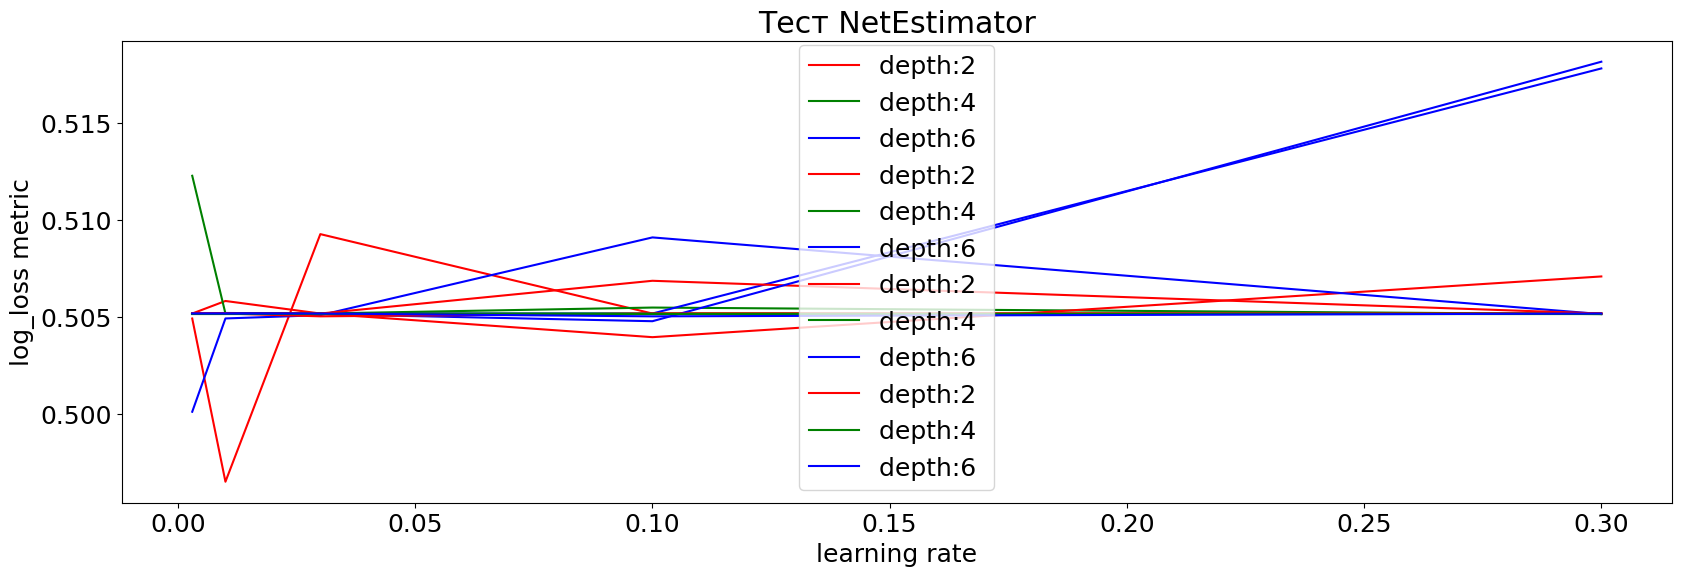

In [58]:
ResultPlotter(nt).plot()

Конкретные выводы по кривой  зависят от уточнения задачи, какие ошибки хуже 

## Проведите анализ важности факторов ДТП

Родной feature importance from lgb  

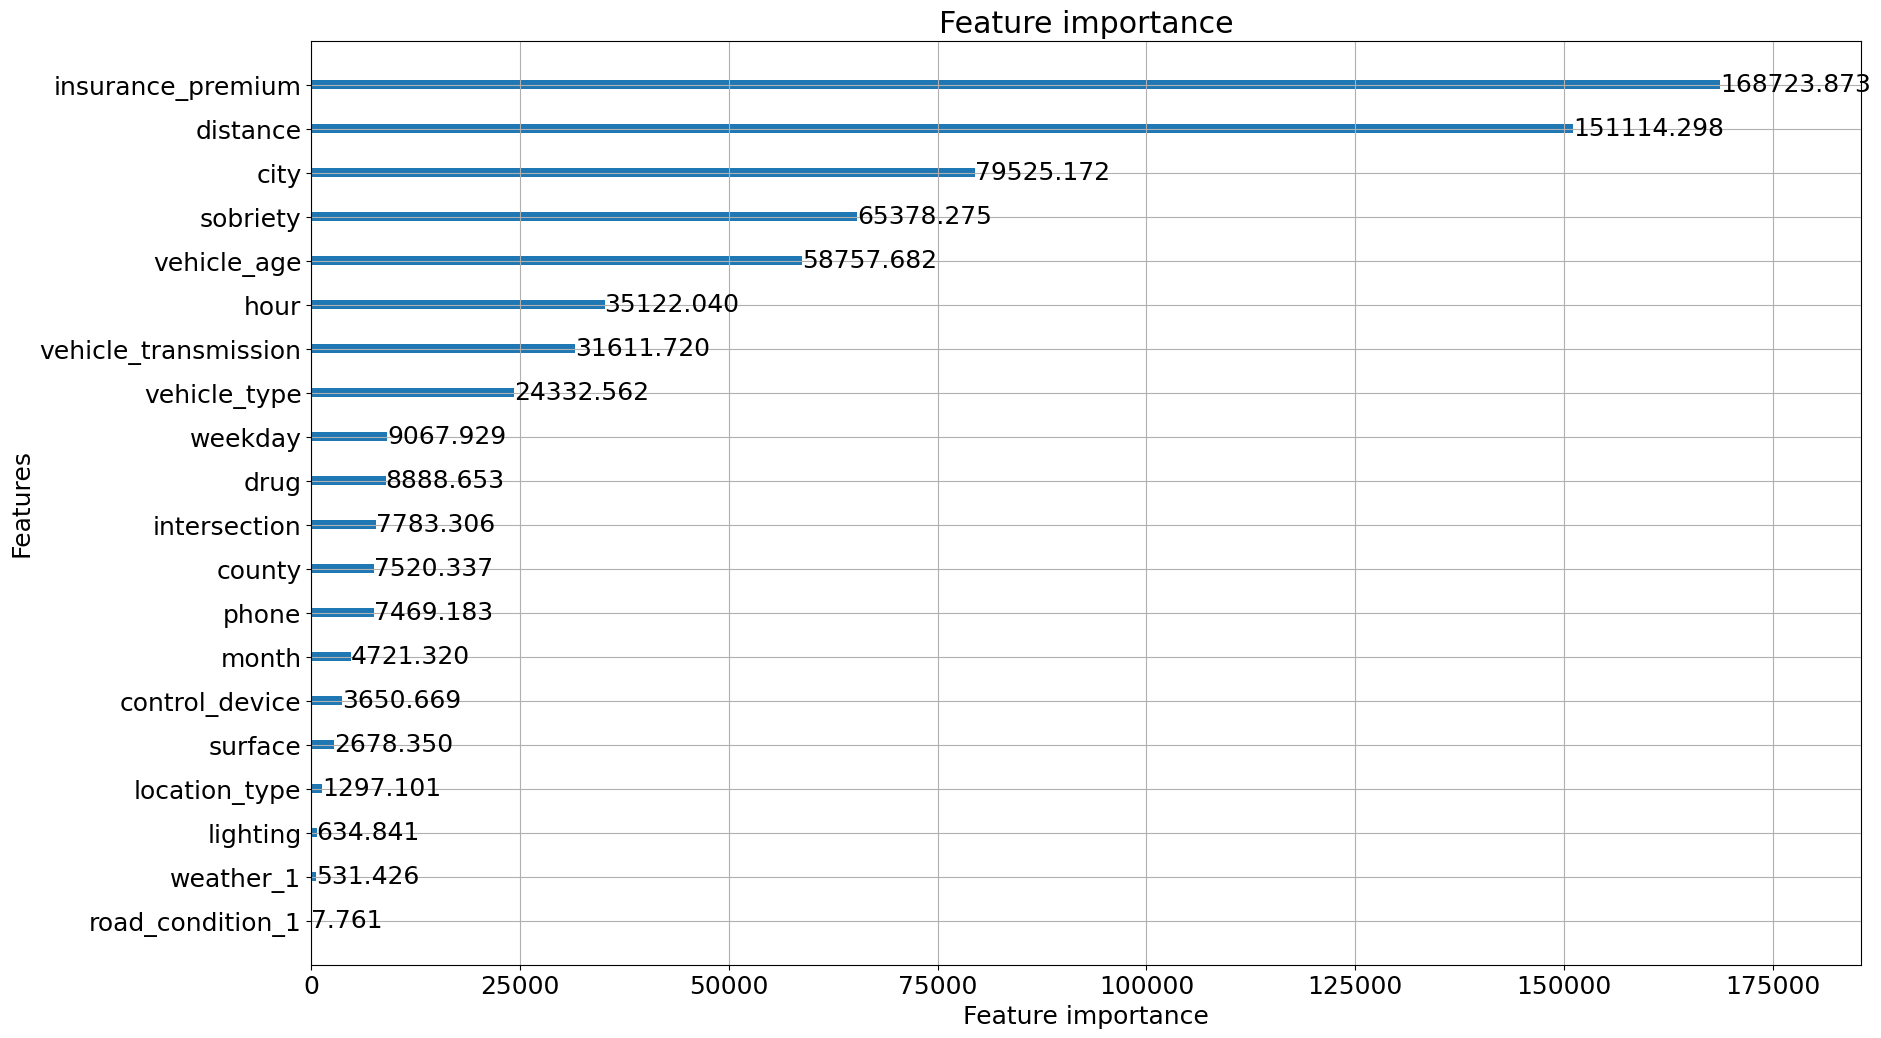

In [59]:
lgb.plot_importance(lgbm.model,importance_type='gain',max_num_features=20,figsize=(20,12) );

и оценка свой модели Catboost'ом

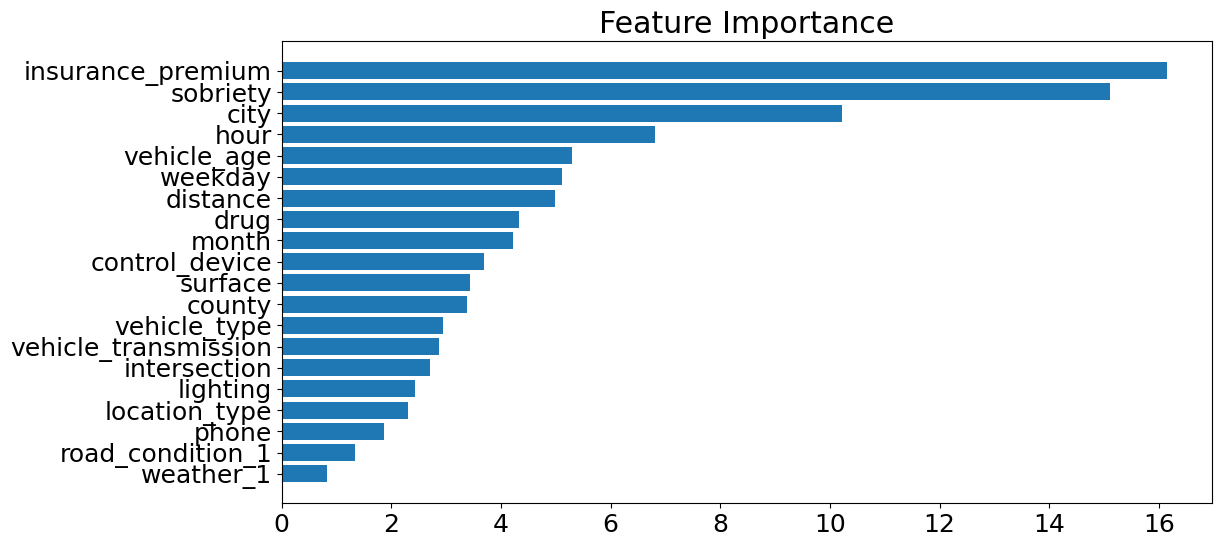

In [60]:
def native_catboost_explanation(cbst,X):
    feature_importance = cbst.model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_te.columns)[sorted_idx])
    plt.title('Feature Importance')
native_catboost_explanation(cbst,X_te)    

при общей схожести оценок, есть отличие в третей позиции и ниже.  
Оценки моделей с помощью SHAP   

In [62]:
expl_lgbm = shap.Explainer(lgbm.model)
values_lgbm = expl_lgbm.shap_values(X_te)[1]
expl_cbst = shap.Explainer(cbst.model)
values_cbst = expl_cbst.shap_values(X_te)

общая 

--------------------------LGBM ------------------->
--------------------------CATBOOST------------------->


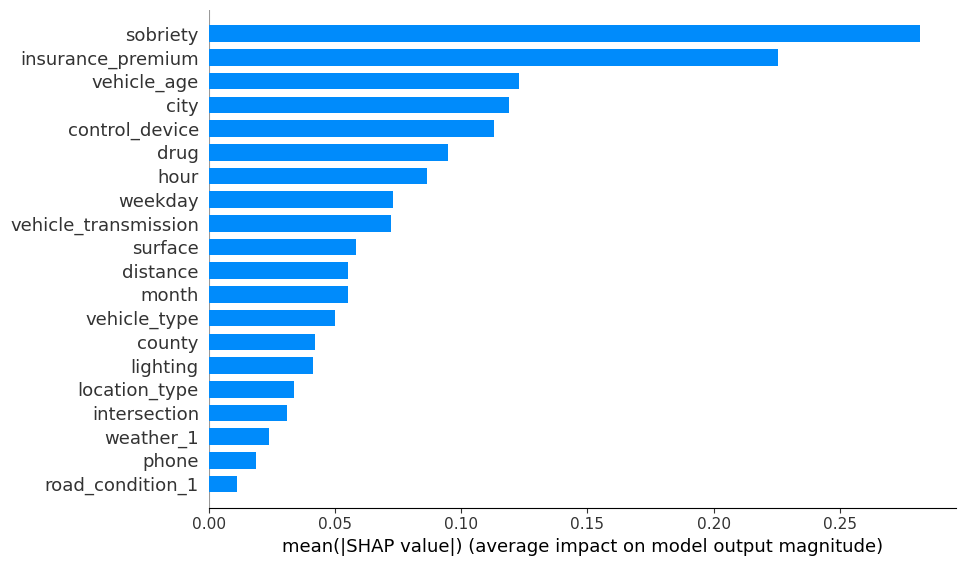

In [63]:
print('--------------------------LGBM ------------------->')
shap.summary_plot(values_lgbm, X_te,plot_type='bar',plot_size=(10,6),title='LGBM')
print('--------------------------CATBOOST------------------->')
shap.summary_plot(values_cbst, X_te,plot_type='bar',plot_size=(10,6),title='Catboost')

 и подробная

In [ ]:
print('--------------------------LGBM ------------------->')
shap.summary_plot(values_lgbm, X_te,plot_type='dot',plot_size=(10,6))
print('--------------------------CatBoost ------------------->')
shap.summary_plot(values_cbst, X_te,plot_type='dot',plot_size=(10,6))

Здесь порядок важности признаков расходится еще сильнее, но в целом можно сделать определенные выводы 
Решающий вклад дают числовые признаки и признаки раздельные для участников (таблица parties)   
<b>Важнейшие признаки- стоимость страховки и состояние опьянения</b>  
Также важным признаком является  возраст машины, причем как показал и предварительный анализ, виновность ниже в середине и выше при крайних значениях.
Из прочих  признаков можно отметить довольно большое влияние города, но это может быть связано со стоимостью страховки или даже с трезвостью. Также влияет время суток(тоже возможно связано с трезвостью).
Погода, состояние дороги, освещение и использование телефона на виновность влияют меньше всего

Примитивный анализ важнейщих признаков выполнен в ч.2.

Хотя SHAP можно применить к оценке MLP классифкатора, там нужен специфический код который работает долго , и в окончательный вариант я его не включил (выводы примерно те же, но с нюансами)

#### Пересмотр задач для рабочей группы 

Исходя из собственного понимания ситуации, я бы сосредоточился на следующих задачах , имея в виду прежде всего основные причины виновности :

##### Определить влияние факторов виновности на общий материальный эффект

Посчитать долю суммы страховок в инцидентах с каждой категорией виновников к общей сумме страховок.  
Хотя такой задачи нет, она неизбежно возникнет, если работа будет продолжаться :)  

* Создать  подзапрос collision_costs к базе данных, вычисляющий для каждого инцидента сумму страховок участников: для этого сгруппировать данные по case_id и вычислить сумму страховок участников для каждого инцидента
* С помощью этого подзавроса посчитать суммарную стоимость страховок для каждой категории виновников по sobriety, для этого связать вторую копию parties c cosllision_costs по саse_id, сгруппировать по sobriety  и отфильтровать по признаку виновности at_fault=1, суммировать стомиость страховок и количество инцидентов по группамб также вычислить средние стоимость инцидентов с помощью функции avg 
* Загрузить запрос в датафрейм, пересчитать количество и суммарную стоимость страховок в проценты  
* Иллюстрировать результаты круговыми диаграммами, сравнить их между собой
* Построить столбчатую диаграмму для средней стоимости инцидента в зависимости от трезвости 

##### Проверить связь объективных факторов с виновностью участников 

На большом расстоянии от трасс и в некоторых городах виновников видимо значительно больше, хотя должно быть поровну :)
Связано ли это с другими факторами (трезвость/страховка) или это независимая тенденция?
Есть ли что-то общее у этих районов? 

Посчитать коэффициент корреляции между долей виновников и долей пьяных по городам:
- Построить запрос:
    - связать таблицы collisions и partis по case_id
    - применить группировку по городу и для каждого города:
    - найти количество записей в базе(count)
    - найти количество виновников,просумировав fault_at
    - найти количество пьяных просуммировав 1 для инцидентов с пьяными водителями
- загрузить запрос в датафрейм
- в датафрейме посчитать доли виновных и пьяных водителей по городам
- найти коэффициент корреляции между этими векторами
- для 10 крупнейших по количеству инцидентов городов вывести доли виновных и пьяных на столбчатую диаграмму


##### Исследовать сложную зависимость виновности от возраста автомобиля

Это третий признак по важности
Есть непонятный миниумум виновности в середине графика , возомжно это результат взаимодействия разнонаправленных тенденций?
Пока не могу сказать , как это проверить .

##### Определить вес категорий страховки в базе инцидентов

Это важный признак и влияние его на виновность велико.  
Возможно, выделяется какая-то одна группа, на которой можно сосредоточиться (хотя по SHAP-dot не похоже)

##### Определить удельный вес пьяных инцидентов в общей базе и сравнить с предыдущим показателем

Частично это сделано во второй части, нужно сравнение с предыдущим показателем по количиству инцидентов с учетом тяжести и по  сумме страховок.  
Если один из этих двух показателей намного больше, нужно сосредоточиться в первую очередь на нём

##### Проверить согласованность базы за предыдущие годы 

Запустить обученные и необученные модели на данных за предыдущие годы.  
Сранить результаты .  
Возможно, есть резкие изменения на которые надо обратить внимание?
Если модели  обучаются заметно лучше на прошлогодних данных, может взять их за основу?  

## Выводы

* Важнейшими факторами , влияющими  на  виновность являются стоимость страховки и степень опъянения, затем - возраст машины  
* Меньше вляиют место и время, нужно проверить возможную зависимость от основных признаков
* Погода и состояние дороги влияют мало
* Предварительно, наиболее устойчивой моделью для предсказания виновности является <br><b>Catboost  с числом итераций >256 и скоростью обучения 0.1-0.3</b>; <br>эта модель позволяет получить метрику F1 c точностью предсказания ~0.65  
* Нужно уточнить постановку задачи - должны ли мы сосредоточиться на предсказании  виновника или на предсказании ущерба? 
* Нужно проверить корректность данных по дистанции от основной трассы
* Нужно пополнить данные за 2012 год или перейти на данные предыдущего года
* Для предсказания не только виновности но и аварийности важно иметь данные по безаварийной езде, например трафик по трассам , перекресткам и городам